TODO: print scatter plot,
as in https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

also, it seems that I do not need to use ranks to compute spearman r

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [2]:
from thesis_v2 import dir_dict
from os.path import join

import pandas as pd
import numpy as np

In [3]:
metric_pkl_loc_k_bl = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218.pkl'
)

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    keygen
)

In [5]:
df_all_k_bl = pd.read_pickle(metric_pkl_loc_k_bl)
# only on test subset
df_all_k_bl = df_all_k_bl.xs('test', level='subset')

In [6]:
def find_sensitive_neurons(series_this, measure, cls_level, baseline_key, improved_key):
    # series_this should be generated by `df_all.xs(...).xs(...)...['val_per']
    
    # base line is performance at rcnn_bl_cls=2
    # improved is performance at rcnn_bl_cls=4 
    # (
    #     or maybe rcnn_bl_cls=3 then /2? 
    # )
    # but I think it's fine, because we have so many models to average out these issues.

    baseline_perf = series_this.xs(key=baseline_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    
    if isinstance(improved_key, int):
        improved_perf = series_this.xs(key=improved_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    else:
        # then summing all together.
        improved_perf = series_this.xs(key=improved_key[0], level=cls_level).xs(key=measure,level='measure').sort_index()
        
        for improved_key_this in improved_key[1:]:
            improved_perf = improved_perf + series_this.xs(key=improved_key_this, level=cls_level).xs(key=measure,level='measure').sort_index()
        
        # all addition and division will work at numpy array level
        improved_perf = improved_perf/len(improved_key)

    assert baseline_perf.index.equals(improved_perf.index)
    
    num_neuron = 79
    
    data = pd.DataFrame({
        'baseline': baseline_perf,
        'improved': improved_perf,
    })
    
    delta_all = np.zeros((num_neuron,), dtype=np.float64)
    bad_case_count = np.zeros((num_neuron,), dtype=np.int64)
    good_case_count = np.zeros((num_neuron,), dtype=np.int64)
    all_case_count = 0
    
    for (k, v) in data.iterrows():
        
        assert isinstance(v['baseline'], np.ndarray)
        assert isinstance(v['improved'], np.ndarray)
        assert v['baseline'].shape == (num_neuron,)
        assert v['improved'].shape == (num_neuron,)
    
        # compute perf gain.
        delta_this = (v['improved'] - v['baseline'])/v['baseline']
        mask_this = v['baseline']!=0
        bad_case_count += np.logical_not(mask_this).astype(np.int64)
        good_case_count += mask_this.astype(np.int64)
        delta_all[mask_this] += delta_this[mask_this]
        all_case_count += num_neuron
        
    
    delta_all /= good_case_count
    print(all_case_count, bad_case_count.sum(), good_case_count.sum(), bad_case_count.sum()/all_case_count)
    return delta_all

In [7]:
from scipy.stats import spearmanr

In [8]:
def plot_scatter(x,y,xlabel,ylabel,title):
    assert x.shape == y.shape
    assert x.ndim == 1
    plt.close('all')
    plt.figure()
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [9]:
def gen_rank(array_this, reverse):
    assert array_this.ndim == 1
    temp = array_this.argsort()
    if reverse:
        temp = temp[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(array_this.size)
    return ranks

def find_sensitive_neurons_wrapper(series_this, cls_level, baseline_key, improved_key, plot=False):
    # using normed or normed does not matter, as that does not affect detla at all.
    delta_mse = find_sensitive_neurons(series_this, 'mse_normed', cls_level, baseline_key, improved_key)
    delta_cc2 = find_sensitive_neurons(series_this, 'cc2_normed', cls_level, baseline_key, improved_key)
    delta_cc = find_sensitive_neurons(series_this, 'cc_normed', cls_level, baseline_key, improved_key)
    
    # create rank for each of them
    # https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice/
    
    # smaller the better,
    rank_mse = gen_rank(delta_mse, reverse=False)
    # bigger better.
    rank_cc = gen_rank(delta_cc, reverse=True)
    # bigger better
    rank_cc2 = gen_rank(delta_cc2, reverse=True)
    
    rank_avg = gen_rank(np.mean([rank_mse, rank_cc, rank_cc2], axis=0), reverse=False)
    
    spear_mse_cc = spearmanr(rank_mse, rank_cc)[0]
    spear_cc_cc2 = spearmanr(rank_cc, rank_cc2)[0]
    spear_mse_cc2 = spearmanr(rank_mse, rank_cc2)[0]
    
    spear_mse_avg = spearmanr(rank_mse, rank_avg)[0]
    spear_cc_avg = spearmanr(rank_cc, rank_avg)[0]
    spear_cc2_vag = spearmanr(rank_cc2, rank_avg)[0]
    
    # let's plot these scatter plots.
    if plot:
        plot_scatter(rank_mse, rank_cc, 'mse rank', 'cc rank', f'cc vs mse {spear_mse_cc}')
        plot_scatter(rank_cc, rank_cc2, 'cc rank', 'cc2 rank', f'cc2 vs cc {spear_cc_cc2}')
        plot_scatter(rank_mse, rank_cc2, 'mse rank', 'cc2 rank', f'cc2 vs mse {spear_mse_cc2}')
        plot_scatter(rank_mse, rank_avg, 'mse rank', 'avg rank', f'avg vs mse {spear_mse_avg}')
        plot_scatter(rank_cc, rank_avg, 'mse rank', 'avg rank', f'avg vs cc {spear_cc_avg}')
        plot_scatter(rank_cc2, rank_avg, 'mse rank', 'avg rank', f'avg vs cc2 {spear_cc2_vag}')
    
    print(spear_mse_cc, spear_cc_cc2, spear_mse_cc2, spear_mse_avg, spear_cc_avg, spear_cc2_vag)
    
    
    
    return {
        'mse': rank_mse,
        'cc': rank_cc,
        'cc2': rank_cc2,
        'avg': rank_avg,
        'delta_mse': delta_mse,
        'delta_cc2': delta_cc2,
        'delta_cc': delta_cc,
    }

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0


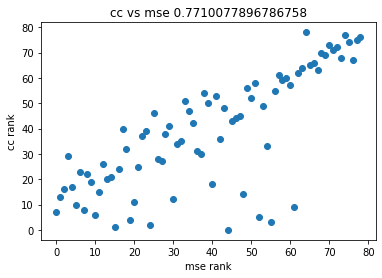

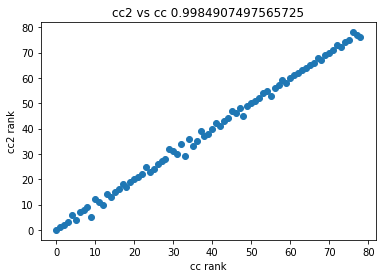

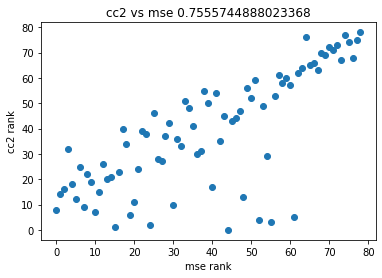

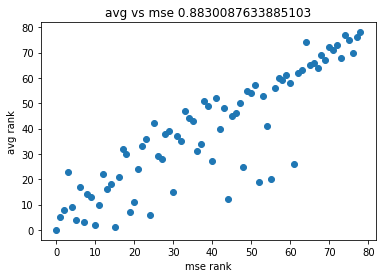

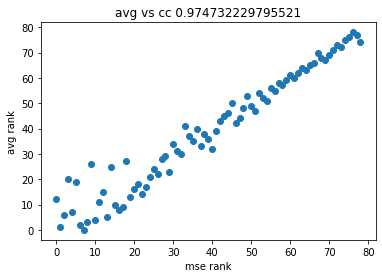

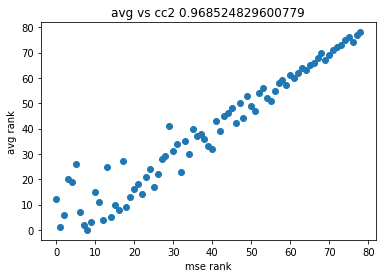

0.7710077896786758 0.9984907497565725 0.7555744888023368 0.8830087633885103 0.974732229795521 0.968524829600779


{'mse': array([54, 35, 51,  0, 60, 23, 72,  8, 57, 76,  6, 68, 13, 71, 33, 49, 73,
        12, 22, 17, 36, 28, 15, 55,  3,  9, 29, 40,  1, 11, 30, 69, 26, 16,
        38, 75, 62, 43, 47, 65, 46, 41, 74, 70, 34, 37, 77, 19, 24, 61, 59,
        42, 27,  2, 56, 48,  4, 66, 53, 14, 67, 78, 32, 18, 50, 45, 25, 31,
        58, 64, 63,  7, 10, 52, 44, 39, 21, 20,  5]),
 'cc': array([33, 42, 58,  7, 57, 39, 72, 22, 61, 67, 23, 70, 20, 71, 51, 56, 68,
        26, 37, 40, 31, 38,  1,  3, 29, 19, 41, 18, 13, 15, 12, 69, 28, 24,
        54, 74, 62, 48, 45, 65, 44, 53, 77, 73, 47, 30, 75,  4,  2,  9, 60,
        36, 27, 16, 55, 14, 17, 66, 49, 21, 63, 76, 35, 32, 52, 43, 46, 34,
        59, 78, 64,  8,  6,  5,  0, 50, 25, 11, 10]),
 'cc2': array([29, 41, 59,  8, 57, 38, 73, 22, 61, 68, 25, 70, 20, 71, 51, 56, 67,
        26, 39, 40, 30, 37,  1,  3, 32, 19, 42, 17, 14, 15, 10, 69, 28, 23,
        55, 74, 62, 45, 47, 65, 44, 54, 77, 72, 48, 31, 75,  6,  2,  5, 60,
        35, 27, 16, 53, 13, 18, 66, 

In [10]:
rank_dict_to_use_k_bl = find_sensitive_neurons_wrapper(df_all_k_bl['val_per'], 'rcnn_bl_cls', 2, 4, plot=True)
rank_dict_to_use_k_bl

In [11]:
dummy = find_sensitive_neurons_wrapper(df_all_k_bl['val_per'], 'rcnn_bl_cls', 2, [3,4])

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.7090555014605647 0.9968841285296982 0.6860029211295035 0.8416017526777021 0.9703748782862708 0.9618062317429407


In [12]:
metric_pkl_loc_pcn = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs.pkl'
)

df_all_pcn = pd.read_pickle(metric_pkl_loc_pcn)

df_all_pcn = df_all_pcn.xs('test', level='subset')

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0


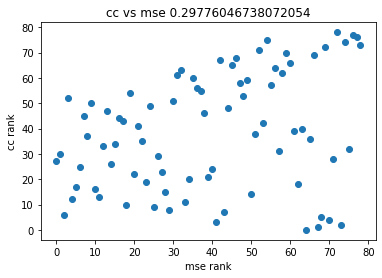

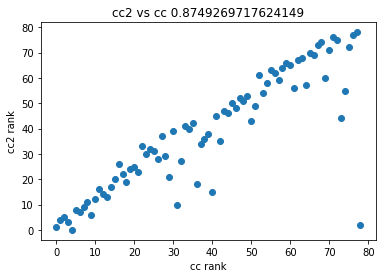

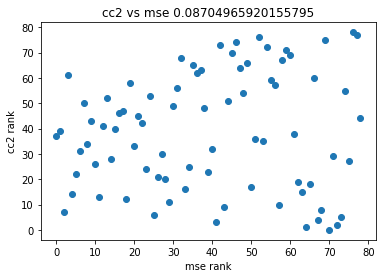

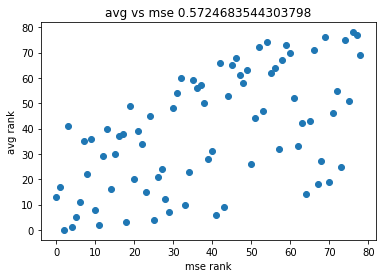

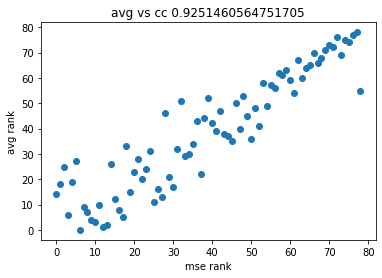

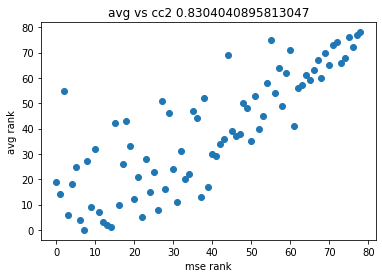

0.29776046738072054 0.8749269717624149 0.08704965920155795 0.5724683544303798 0.9251460564751705 0.8304040895813047


In [13]:
# bad consistency, not study it.
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, (2,3,4,5), plot=True)

In [14]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 3)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.35107108081791627 0.8829113924050633 0.13770691333982474 0.6091041869522883 0.9284079844206428 0.8339094449853944


In [15]:
rank_dict_to_use_pcn = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 2)
rank_dict_to_use_pcn

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.45384615384615384 0.8879746835443038 0.2687439143135346 0.6596884128529699 0.9453018500486856 0.8661879259980526


{'mse': array([46, 32,  9,  0, 26, 30, 74, 19, 27, 73, 67, 78,  4, 70, 23, 33, 34,
        22, 12,  5, 40, 16, 21, 59,  7, 36, 29, 58,  2, 51, 57, 49, 56, 17,
         8, 31, 76,  1, 45, 39, 25, 69, 52, 60,  3, 24, 75, 18, 50, 53, 35,
        14, 48,  6, 65, 68, 15, 71, 28, 13, 55, 77, 64, 66, 54, 43, 42, 41,
        38, 63, 62, 72, 20, 47, 61, 37, 10, 44, 11]),
 'cc': array([14, 23, 46, 29, 25,  4, 76, 42, 11, 68, 66, 77, 10, 69, 32, 57, 24,
        60, 35, 33, 56, 31,  5,  1, 52, 53, 27, 65, 30, 59, 18, 39, 64, 51,
        17, 13, 62,  7, 54, 37, 21, 75, 34, 70, 20, 40, 71,  8,  3,  6, 48,
        12, 47, 41, 67, 15, 38, 28, 55, 43, 26, 74,  9, 73, 63, 19, 44, 58,
        45, 78, 61, 72, 16,  2,  0, 49, 22, 50, 36]),
 'cc2': array([17, 26, 53, 33, 28,  2, 74, 45,  7, 71, 47, 78, 12, 64, 31, 68, 21,
        69, 41, 38, 65, 37, 10,  1, 63, 60, 29, 54, 36, 66, 19, 35, 56, 59,
        16, 11, 49,  8, 61, 32, 25, 77, 30, 72, 24, 44, 75, 14,  5,  9, 52,
        18, 42, 48, 58, 20, 39, 23, 

In [16]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 4)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.38186465433300876 0.8805014605647518 0.1702775073028238 0.6358812074001948 0.9323271665043817 0.8365384615384616


In [17]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 5)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.34532619279454724 0.862682570593963 0.11755111976630965 0.6090555014605649 0.9217380720545278 0.8213729308666019


In [18]:
# given above results, we should analyze top ranking neurons in k_bl, which gives more consistent ranking.

# it's interesting that actually the ranking between two models are not that related.

In [19]:
spearmanr(
    rank_dict_to_use_pcn['avg'],
    rank_dict_to_use_k_bl['avg']
)

SpearmanrResult(correlation=0.363510223953262, pvalue=0.0009917032960917668)

In [20]:
# ok. then study those 

[-3.71926271 -1.74527224 -1.50144999 -1.45700441 -1.40500885 -1.35834116
 -1.32763303 -1.20166916 -1.16888126 -1.12274589]


array([ 3, 28, 53, 24, 56, 78, 10, 71,  7, 25, 72, 29, 17, 12, 59, 22, 33,
       19, 63, 47, 77, 76, 18,  5, 48, 66, 32, 52, 21, 26, 30, 67, 62, 14,
       44,  1, 20, 45, 34, 75, 27, 41, 51, 37, 74, 65, 40, 38, 55, 15, 64,
        2, 73, 58,  0, 23, 54,  8, 68, 50,  4, 49, 36, 70, 69, 39, 57, 60,
       11, 31, 43, 13,  6, 16, 42, 35,  9, 46, 61])

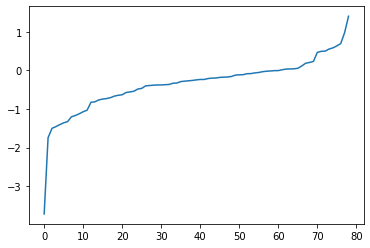

In [21]:
plt.plot(rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['mse'])]*100)
print((rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['mse'])]*100)[:10])
np.argsort(rank_dict_to_use_k_bl['mse'])

[-3.71926271 -0.74289917 -1.07086465 -1.20166916 -1.35834116 -1.74527224
 -0.48279469 -0.64413648 -1.50144999 -1.40500885]


array([ 3, 22, 72, 71, 78, 28, 48, 47, 53, 56, 29, 77, 74, 25,  7, 30, 12,
       10, 59, 73, 23, 33, 17, 24, 76, 55, 49, 27, 52, 32, 63, 20, 19, 18,
       45, 62,  5, 67, 21, 26, 51,  0, 66,  1, 44, 65, 40, 14, 37, 75, 38,
       34, 41, 58, 64, 15, 54,  2,  4, 68,  8, 50, 36, 70, 60, 39, 57, 31,
       16, 11,  9, 13, 43,  6, 69, 35, 46, 42, 61])

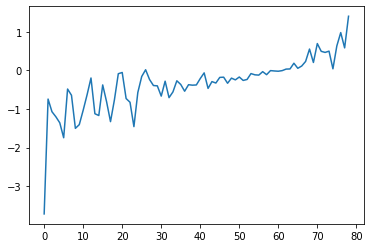

In [22]:
plt.plot(rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['avg'])]*100)
print((rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['avg'])]*100)[:10])
np.argsort(rank_dict_to_use_k_bl['avg'])

In [23]:
def normalize_rf_map(map_this):
    assert map_this.shape == (10,14,14)
    map_this = map_this.copy()
    for k in range(map_this.shape[0]):
        map_this[k] = abs(map_this[k])
        map_this[k] /= map_this[k].sum()
    # each slice sum to one
    return map_this

from skimage.transform import resize

In [24]:
# neuron 3 (0-indexed) has best improvement. probably let's also study neuron 71.

from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_indices

from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules
from torchnetjson.builder import build_net


load_modules()

_cache_get_all_data_for_related_neurons = dict()

def get_all_data_for_related_neurons(specific_neuron_list):
    
    if tuple(specific_neuron_list) in _cache_get_all_data_for_related_neurons:
        return _cache_get_all_data_for_related_neurons[tuple(specific_neuron_list)]
    
    
    dir_response = join(
        dir_dict['analyses'],
        'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218'
    )
    param_list = []
    resp_all = []
    rf_map_all = []
    
    
    for idx, param in enumerate(param_iterator_obj().generate()):
        
        assert len(param) == 22
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        assert param['rcnn_acc_type'] == 'cummean'
        
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
#         print(key)
        
        file_to_load_this = join(dir_response, key, 'test' + '.npy')
        
        resp = np.load(file_to_load_this)
        assert resp.shape == (1600, 79)
        resp = resp[:, specific_neuron_list]
        assert resp.shape == (1600, len(specific_neuron_list))
        param_list.append(param)
        resp_all.append(resp)
        
        
        
        # load model params.
        result = load_training_results(key, return_model=False,return_checkpoint=True)
        rf_map = result['checkpoint']['model']['moduledict.fc.weight_spatial'].numpy()
        assert rf_map.shape == (79, 14, 14)
        
        rf_map = rf_map[specific_neuron_list]
        assert rf_map.shape == (len(specific_neuron_list), 14, 14)
        rf_map_all.append(rf_map)
        
    resp_all = np.asarray(resp_all)
    
    _cache_get_all_data_for_related_neurons[tuple(specific_neuron_list)] = param_list, resp_all, rf_map_all
    
    return _cache_get_all_data_for_related_neurons[tuple(specific_neuron_list)]
    

def load_gt(specific_neuron_list):
    # load ground truth response.
    data_gt = get_data('a', 200, 50,
             ('042318', '043018', '051018'),
             scale=0.5,
             seed='legacy')[5]
    assert data_gt.shape == (1600, 79)
    data_gt_subset = data_gt[:,specific_neuron_list]
    assert data_gt_subset.shape == (1600, len(specific_neuron_list))
#     datasets = get_data_cached(param['input_size'], param['split_seed'])


#         datasets = {
#             'X_train': datasets[0].astype(np.float32),
#             'y_train': datasets[1],
#             'X_val': datasets[2].astype(np.float32),
#             'y_val': datasets[3],
#             'X_test': datasets[4].astype(np.float32),
#             'y_test': datasets[5],
#         }
    return data_gt_subset

def study_specific_neurons(base_key, improved_key):
    specific_neuron_list = [3, 78, 28, 53, 24, 56, 10, 71,  7, 25]
    
    
    
#     base_key = 2
#     improved_key = 4
    for n_idx in specific_neuron_list:
        series_this = df_all_k_bl['val_per'].apply(lambda x: x[n_idx])
        # get it's metrics.
        
        
        for measure in ('mse', 'cc', 'cc2'):
            baseline_perf = series_this.xs(
                key=base_key, level='rcnn_bl_cls'
            ).xs(
                key=measure, level='measure'
            ).sort_index()

            improved_perf = series_this.xs(
                key=improved_key, level='rcnn_bl_cls'
            ).xs(
                key=measure, level='measure'
            ).sort_index()

            assert baseline_perf.index.equals(improved_perf.index)

            print(n_idx, measure,
                  baseline_perf.values.mean(),
                  improved_perf.values.mean(),
                  (improved_perf.values.mean()-baseline_perf.values.mean())/baseline_perf.values.mean()*100
                 )
    
    # ok. time to get the responses for all these neurons.
    param_list, resp_all, rf_map_all = get_all_data_for_related_neurons(specific_neuron_list)
    print(resp_all.shape)
    assert len(param_list) == len(rf_map_all)
    
    # get mask.
    # 1. easist way, using every one's RF estimate.
#     rf_map_all = np.asarray([normalize_rf_map(z) for z, y in zip(rf_map_all, param_list)   if y['rcnn_bl_cls'] == base_key ])
    
    # 1. easist way, using every one's RF estimate.
    # other ones give similar results.
    rf_map_all = np.asarray([normalize_rf_map(z) for z in rf_map_all])
    
    rf_map_all = np.mean(rf_map_all, axis=0)
    print(rf_map_all.shape)
    
    
    # let's check the numbers obtained above, again.
    baseline_resp = resp_all[[i for i, z in enumerate(param_list) if z['rcnn_bl_cls'] == base_key]]
    improved_resp = resp_all[[i for i, z in enumerate(param_list) if z['rcnn_bl_cls'] == improved_key]]
    
    data_gt_subset = load_gt(specific_neuron_list)
    
    result_dict=dict()
    assert baseline_resp.shape == improved_resp.shape
    for n_idx_idx, n_idx in enumerate(specific_neuron_list):
        
        rf_map_this = rf_map_all[n_idx_idx]
        assert rf_map_this.shape == (14, 14)
        plt.close('all')
        print(rf_map_this.min(), rf_map_this.max())
        plt.imshow(rf_map_this, cmap='gray',
                   vmin = rf_map_this.min(),
                   vmax = rf_map_this.max())
        plt.show()
        
        baseline_resp_this = baseline_resp[:,:,n_idx_idx]
        improved_resp_this = improved_resp[:,:,n_idx_idx]
        gt_this = data_gt_subset[:,n_idx_idx]
        
        se_per_img_baseline = (gt_this - baseline_resp_this)**2
        se_per_img_improved = (gt_this - improved_resp_this)**2
        
        mse_baseline = se_per_img_baseline.mean()
        mse_improved = se_per_img_improved.mean()
        
        # match what's above.
        print(n_idx, 'mse', mse_baseline, mse_improved, (mse_improved-mse_baseline)/mse_baseline*100)
        
        # time to check per image result.
        se_per_img_baseline_across_config = se_per_img_baseline.mean(axis=0)
        se_per_img_improved_across_config = se_per_img_improved.mean(axis=0)
        assert se_per_img_improved_across_config.shape == se_per_img_baseline_across_config.shape == (1600,)
        
        # let's plot something, like what I plot for errors.
        # hope that we can find some images with consistently lower errors.
        
        delta_per_img =  (se_per_img_improved_across_config-se_per_img_baseline_across_config)
        img_arg_sort = np.argsort(delta_per_img)
        delta_per_img_sorted = delta_per_img[img_arg_sort]
        plt.close('all')
        plt.plot(delta_per_img_sorted)
        plt.show()
        
        
        
        print(delta_per_img_sorted[:10]*100)
        
        plt.close('all')
        plt.plot(delta_per_img_sorted[:100])
        plt.show()
        print(delta_per_img_sorted[-10:]*100)
        
        plt.close('all')
        plt.plot(delta_per_img_sorted[-100:])
        plt.show()
        
        print(img_arg_sort[:20])
        print(img_arg_sort[-20:])
        
        result_dict[n_idx_idx, n_idx] = {
            'img_arg_sort': img_arg_sort,
            'rf_map': rf_map_this,
        }
    return result_dict

3 mse 0.00892429181763111 0.008580933471177324 -3.8474576299201306
3 cc 0.7181464745259194 0.7313461674261278 1.8380223768308688
3 cc2 0.5163469913902053 0.535410437996871 3.691983670775257
78 mse 0.023422042751403374 0.023098115372092613 -1.383002254537994
78 cc 0.5554408629812047 0.5642003729902269 1.5770373756816318
78 cc2 0.3088354729891089 0.3185382081428532 3.1417165456529275
28 mse 0.05143673095684314 0.050522423582731714 -1.7775378744006012
28 cc 0.6085340092344295 0.6175809056220248 1.4866706297938685
28 cc2 0.3706389762322546 0.3818032764899355 3.0121765312358764
53 mse 0.019991194718642243 0.019684187155898262 -1.5357139333833303
53 cc 0.6258088428717179 0.6334693141183977 1.2240912435061388
53 cc2 0.39193527564573055 0.40152623270752397 2.447076764394808
24 mse 0.03475173934070886 0.03423267870116428 -1.4936249217792132
24 cc 0.7383238202591218 0.7429202526447 0.6225496536147245
24 cc2 0.5452785847011163 0.552092944594856 1.249702461261126
56 mse 0.04656635675406007 0.04589

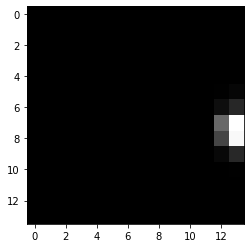

3 mse 0.00892429181763111 0.008580933471177322 -3.84745762992015


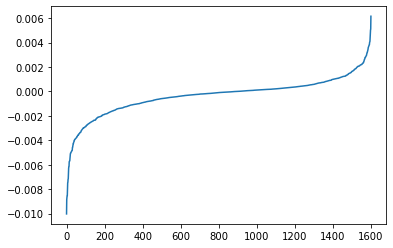

[-1.00210791 -0.88479988 -0.86345084 -0.85348164 -0.85275137 -0.79157015
 -0.74798581 -0.74251055 -0.71903482 -0.71474695]


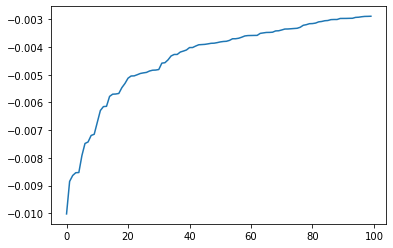

[0.38105434 0.38199069 0.39997877 0.40455358 0.41102082 0.44388135
 0.49104836 0.5033557  0.51071185 0.61602831]


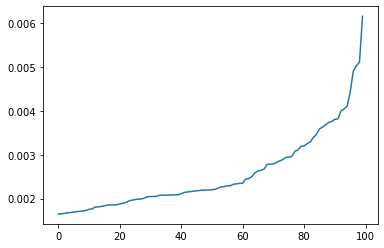

[ 942   42 1389  211  824  714  668  141  648  728  767   98 1047  156
 1556  798 1502 1348  637  178]
[1419   33   19 1288  153  106  431 1583 1045  131  585  542   28  770
 1373  554  325 1073  319 1582]
6.469276e-05 0.2450698


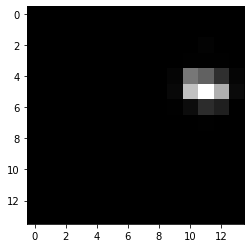

78 mse 0.02342204275140337 0.02309811537209262 -1.38300225453795


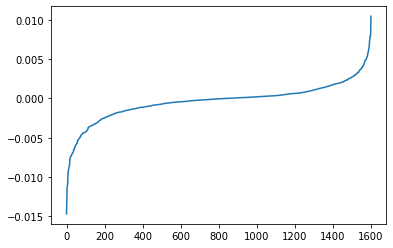

[-1.46821808 -1.33181625 -1.24510985 -1.13425748 -1.11541391 -1.09809912
 -1.0894878  -1.01228783 -0.92968094 -0.92769929]


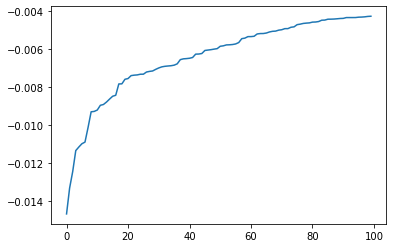

[0.65567653 0.70405236 0.73600688 0.74322065 0.77994281 0.78553599
 0.7856119  0.81117137 0.82064543 1.04622253]


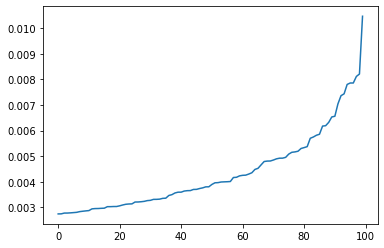

[1065  887 1339 1488   12  942 1371  806 1142  504  607  878 1179 1115
  529  895 1405  289 1395 1360]
[1587  300 1555  111  174  763  886  299  390 1172   49 1354 1026  136
 1528  303 1076  610  518  966]
8.4911844e-05 0.30630425


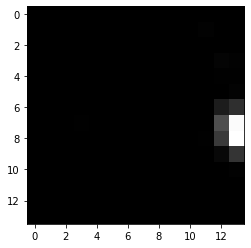

28 mse 0.05143673095684313 0.050522423582731714 -1.7775378744005879


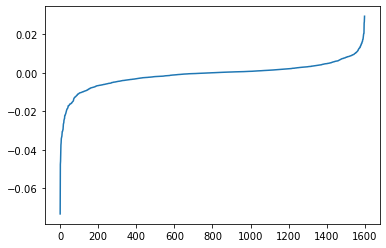

[-7.31928286 -4.74405598 -4.59187833 -4.03869529 -3.74078444 -3.63473746
 -3.41464002 -3.36373652 -3.34116107 -3.28061228]


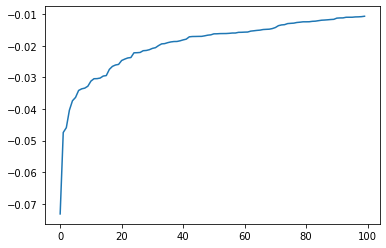

[1.72833867 1.73268776 1.82939109 1.96305774 1.99430732 2.03815588
 2.04519909 2.57691193 2.65766847 2.9339525 ]


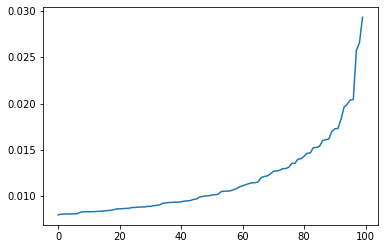

[ 182  407  736  688 1464 1393  995  703  897 1259  448 1329  924  758
  670 1319 1197  883 1301 1067]
[1150  951 1200  960 1469   19  325  843   36    2 1069  302 1570  727
 1155  373  164  769 1191 1564]
5.3480846e-05 0.2715168


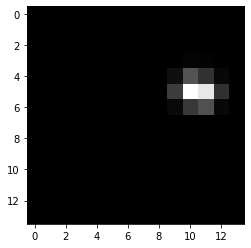

53 mse 0.01999119471864224 0.01968418715589826 -1.5357139333833305


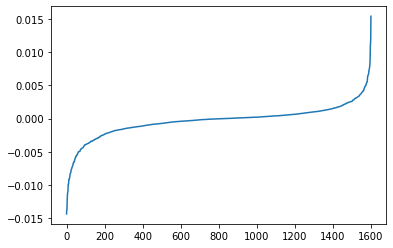

[-1.4339459  -1.37670451 -1.37196356 -1.25999977 -1.1855177  -1.12861417
 -1.11285559 -1.10159453 -1.05257426 -0.98993297]


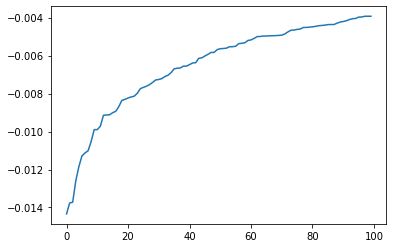

[0.74226822 0.75417767 0.76967324 0.79927349 0.83795594 0.91230853
 1.08485473 1.14223432 1.1913978  1.54106837]


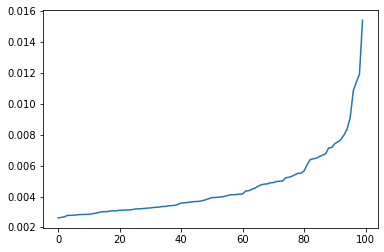

[ 568 1118  683  942 1504  981  631  907  486 1115  762 1176  485  566
  818  887  782  548  668  164]
[ 323  155 1320 1336  200  921  936  259 1089  854  911  143 1308 1328
 1488  500  435 1043  264  964]
6.674334e-05 0.4055041


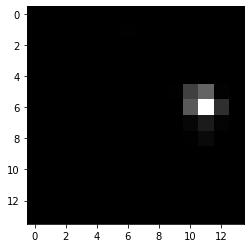

24 mse 0.034751739340708854 0.03423267870116427 -1.4936249217792334


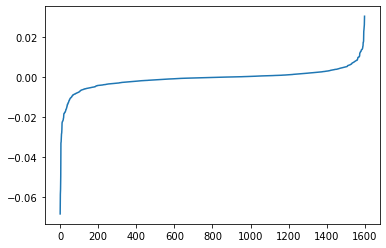

[-6.82466988 -5.84288178 -5.59560655 -4.95731175 -3.27489882 -3.22451333
 -2.98460796 -2.82456432 -2.77845115 -2.61147641]


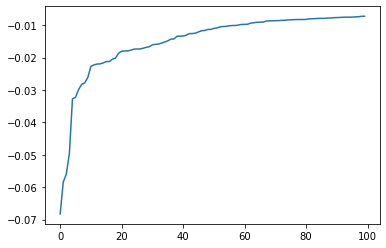

[1.55213893 1.57788915 1.75515509 1.76340232 1.82128395 2.30619025
 2.39351824 2.54041192 2.63402476 3.06254426]


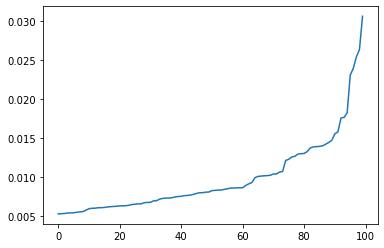

[ 766 1339 1209  603   40  728  373 1317 1107 1037  964 1040  808  110
  531 1469  167 1054 1228  217]
[1038  178 1191 1521  535 1239 1010   50  574  895  579 1150  814  793
  417 1485  683  854 1177  567]
6.76958e-05 0.25242934


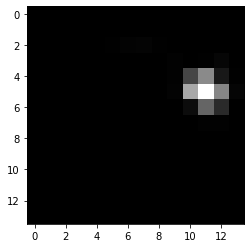

56 mse 0.04656635675406007 0.04589950109066352 -1.432054620288508


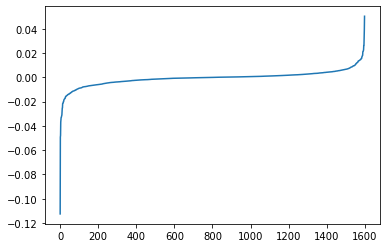

[-11.2493372   -4.92772159  -4.78348448  -3.69622283  -3.51000166
  -3.32046083  -3.29998208  -3.21788624  -3.11194046  -3.09836603]


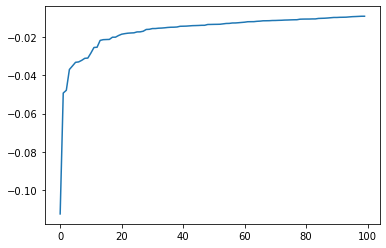

[2.07779965 2.1383817  2.14231198 2.1840042  2.27585731 2.61547256
 2.62204198 3.21570573 3.92863075 5.02400416]


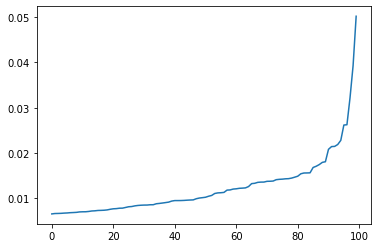

[ 683  895  631  958  887  909  486 1107 1583  435  364 1049  432  472
 1050 1368 1216 1479  819 1483]
[1172  164  474  143  447  339  309  408 1494  939  236  827   30 1405
  642  763  981 1574  801   12]
7.704771e-05 0.49834082


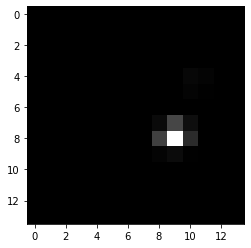

10 mse 0.040439578608440774 0.03988936435338833 -1.3605835520195082


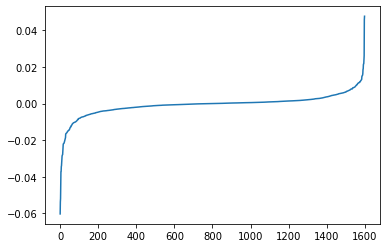

[-6.02594045 -5.37438718 -5.18893669 -4.4487558  -3.7175981  -3.7083893
 -3.43799911 -3.39334086 -3.21828811 -3.0354689 ]


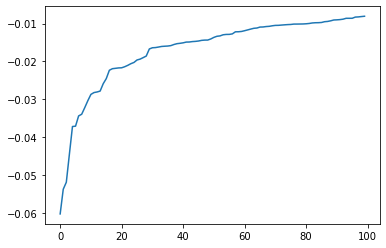

[1.651306   1.88000774 1.89460366 2.13129235 2.17848886 2.18360128
 2.37237088 2.622235   4.59414294 4.7772611 ]


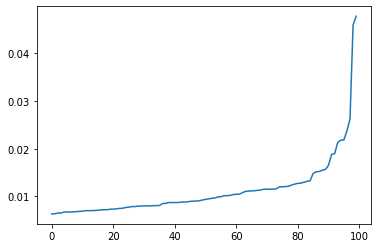

[1246  557  845 1108 1008  892  103 1579  814 1381  866 1275  475  772
  893   81 1057  719  638 1410]
[1282 1207 1007  769   52  585  469  458  119 1144  997  803  151 1377
  461 1185 1451  917  535  914]
0.0010624479 0.056915045


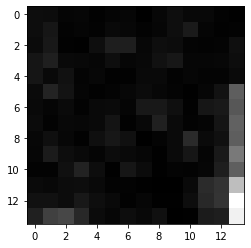

71 mse 0.6817333908839205 0.6733281932705254 -1.2329156420660419


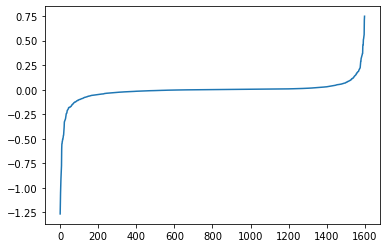

[-126.54340921 -111.61166821 -105.23174741  -95.39851607  -91.28729463
  -87.17773157  -81.98133082  -77.39224773  -60.63088828  -55.11021726]


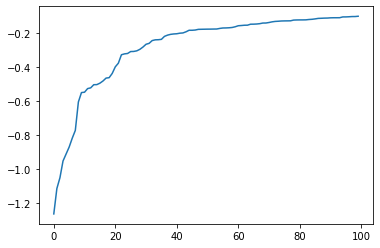

[44.65038399 45.63631681 45.65245632 51.08038342 51.72831205 53.0187217
 53.89597688 56.23442216 70.98615754 74.86855235]


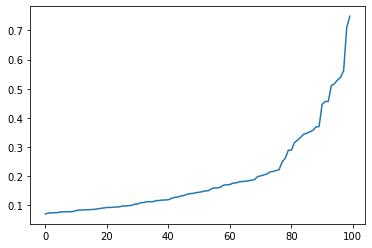

[ 657 1332  884  225 1093 1247  291  274  176  603 1001  590 1502  601
 1132  289 1243  257  330  529]
[1569  761  540  989  304 1066 1302 1065  718  335 1387 1487 1446 1175
 1391   90  993 1541 1110 1479]
6.280133e-05 0.26093712


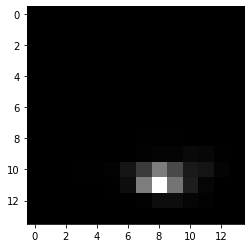

7 mse 0.04411429971463613 0.04358465123002753 -1.2006276604973023


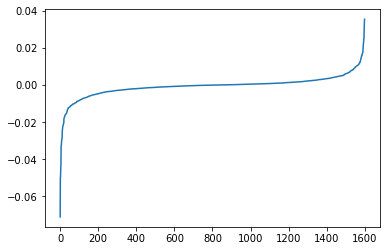

[-7.10094428 -4.96167107 -4.93044893 -4.42417824 -4.3717164  -3.28737776
 -3.24919639 -3.08266903 -2.93324583 -2.92327188]


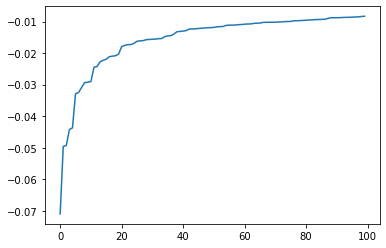

[1.73434952 1.95662384 2.10063461 2.23653965 2.27636492 2.48333747
 2.4985403  3.0720216  3.32229403 3.548391  ]


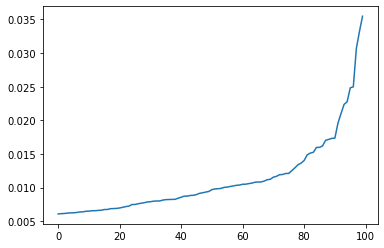

[ 280 1438  796 1454  197  164 1544  996  623 1467   89    7 1333  144
  745 1413 1530 1228  361  844]
[ 528 1577 1268  467  147  944  764 1199 1480 1296 1330  859  997  577
 1416  233 1107  710  572 1373]
8.606591e-05 0.34012675


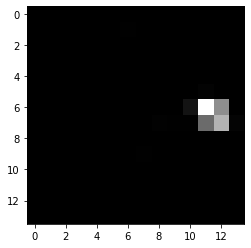

25 mse 0.05359167333053797 0.05297678786472574 -1.1473526158061824


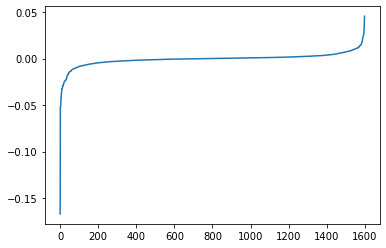

[-16.7022579   -5.20898074  -5.07222309  -5.00945985  -4.3514869
  -4.0622394   -3.94661336  -3.60396702  -3.54715798  -3.23206925]


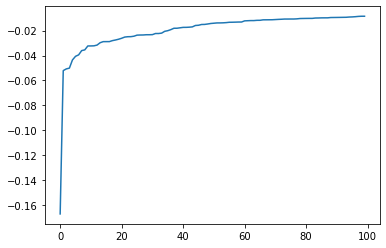

[2.24162927 2.34531143 2.42445242 2.46917491 2.51596998 2.61527878
 2.77607356 3.51311605 3.87592305 4.54606232]


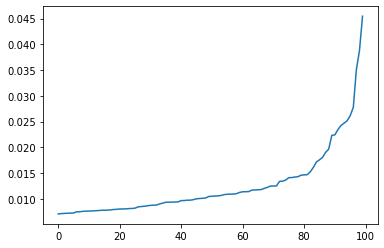

[ 642  751 1242 1467  126  109 1107  307  594  506  492  662 1261 1069
  883  232  726   62 1042  535]
[ 399 1151 1504 1041 1128  582 1115  369  512  999 1337 1426  937 1129
  898  123  370 1116 1282 1235]


In [25]:
result_dict_2to4 = study_specific_neurons(2,4)

3 mse 0.009633592872758783 0.00892429181763111 -7.362788364592271
3 cc 0.6906226410794156 0.7181464745259194 3.985365061806419
3 cc2 0.4783099068085555 0.5163469913902053 7.952393216240503
78 mse 0.024176736152679273 0.023422042751403374 -3.1215685877113866
78 cc 0.5342923666653753 0.5554408629812047 3.9582254277412465
78 cc2 0.28637392669761313 0.3088354729891089 7.843432728152407
28 mse 0.05356420327503947 0.05143673095684314 -3.971817348373994
28 cc 0.5861812300309368 0.6085340092344295 3.8132881194972663
28 cc2 0.3442984287242717 0.3706389762322546 7.650498901659966
53 mse 0.020800673483868704 0.019991194718642243 -3.891598826616005
53 cc 0.6049255042758288 0.6258088428717179 3.452216586716582
53 cc2 0.3666759339242504 0.39193527564573055 6.888737270305374
24 mse 0.036032062376495 0.03475173934070886 -3.553288242033401
24 cc 0.7268248633482791 0.7383238202591218 1.5820808410254708
24 cc2 0.5284537370720271 0.5452785847011163 3.1837881821613476
56 mse 0.04849024106930061 0.046566356

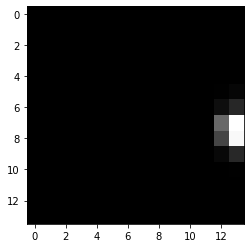

3 mse 0.009633592872758783 0.00892429181763111 -7.362788364592271


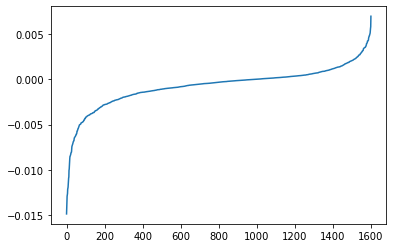

[-1.48941084 -1.40901929 -1.35016785 -1.29261463 -1.28118686 -1.26557366
 -1.2167945  -1.20132411 -1.19407531 -1.15472162]


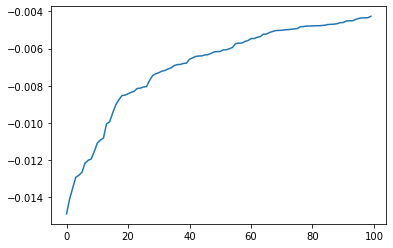

[0.48187019 0.48274803 0.49061604 0.49900138 0.50725382 0.5143634
 0.54722814 0.5665527  0.58398377 0.7003163 ]


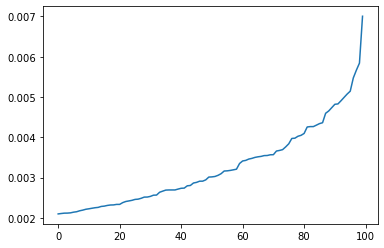

[ 942  824  211   42 1389  798  728  668  141  648  767  743  108  869
  156 1348 1502   98  113  754]
[1525  789  667 1544 1120 1186 1318   20  425 1373  106 1004 1045 1419
  319 1284 1437 1582 1288  554]
6.469276e-05 0.2450698


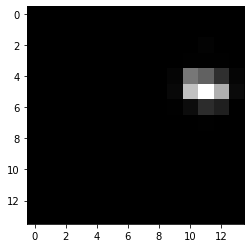

78 mse 0.02417673615267927 0.02342204275140337 -3.121568587711387


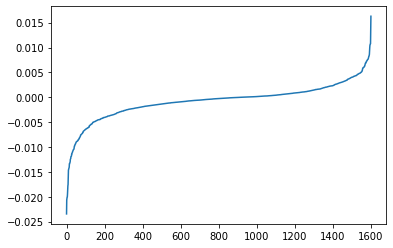

[-2.3459048  -2.06506306 -2.03172523 -2.01032963 -2.00654848 -1.94826012
 -1.83410905 -1.78245852 -1.75483032 -1.59619698]


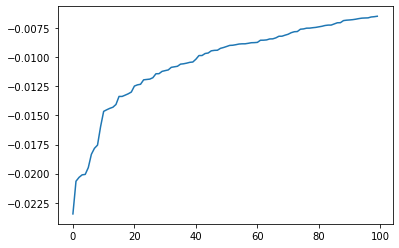

[0.84826548 0.86125849 0.9445192  1.00395003 1.04764254 1.06056478
 1.07151395 1.07500682 1.43983648 1.62872759]


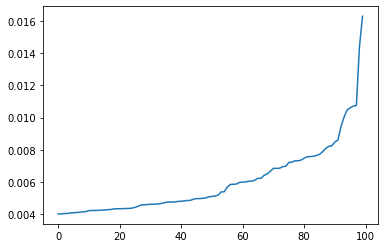

[1065 1371  878  806 1339 1142 1295 1179  529  550  942 1311 1389 1416
  289  768  156  818 1443  607]
[1386  736 1591 1206  843  817 1026  883  763 1172 1131 1175 1150 1076
  303 1068  355  136  966  610]
8.4911844e-05 0.30630425


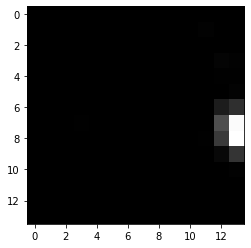

28 mse 0.053564203275039475 0.05143673095684313 -3.9718173483740196


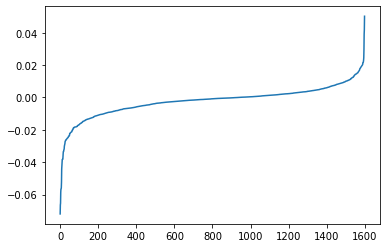

[-7.19184231 -6.63900321 -6.53035892 -5.86730559 -5.65826288 -5.64571468
 -5.57234717 -5.22943465 -4.4306744  -4.20955516]


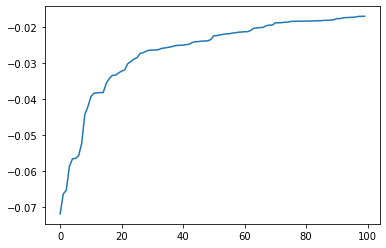

[2.13685927 2.15582278 2.15789465 2.20677753 2.30145535 2.45615809
 2.97573921 3.91740662 4.17705508 5.0183142 ]


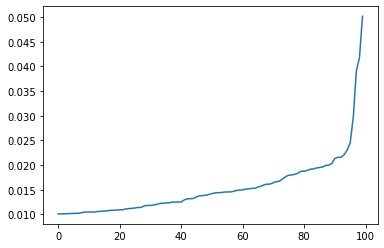

[ 182 1393  346 1107 1197 1464  139  736 1067  670  798  995 1377  443
  722  235  758  407 1583 1301]
[1241  171 1293 1265  435  817  380 1145 1069 1120  866  411  164  843
 1416    2 1221 1332  988 1191]
5.3480846e-05 0.2715168


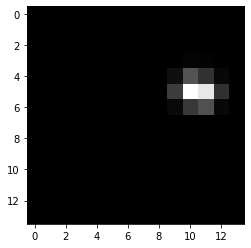

53 mse 0.020800673483868708 0.01999119471864224 -3.8915988266160375


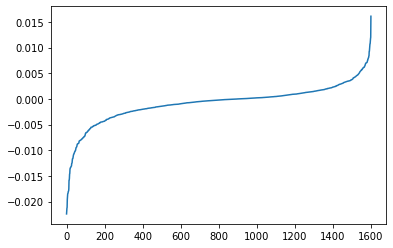

[-2.23969512 -2.16611898 -2.12895352 -2.11191687 -1.96032306 -1.89836436
 -1.85202685 -1.84403403 -1.83211346 -1.80606363]


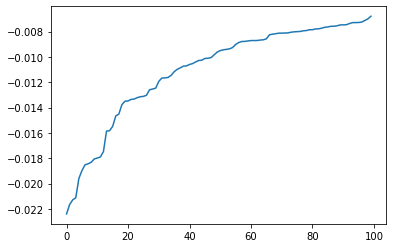

[0.92297816 0.92715622 0.97897811 1.02165544 1.07048125 1.07476919
 1.13404436 1.17264904 1.2020623  1.60976616]


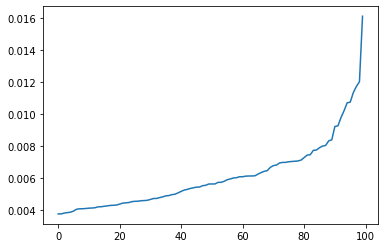

[ 683  818  942 1179  762  668 1389 1118   42  768  878 1345 1582  142
 1416  571 1443  907  225  806]
[ 712 1447  705 1456 1043 1031 1308 1488  764  264 1468  445 1595  159
   16  610 1515  218  280  500]
6.674334e-05 0.4055041


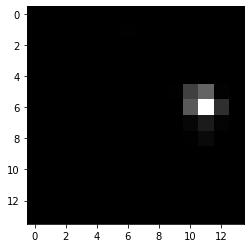

24 mse 0.036032062376495005 0.034751739340708854 -3.5532882420334393


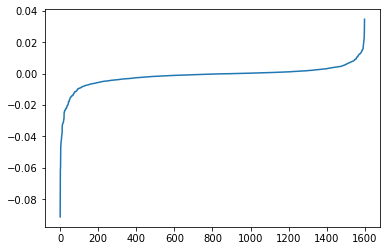

[-9.12389619 -6.1614322  -5.92860552 -4.67702955 -4.49386886 -4.31204428
 -4.27395083 -4.10196342 -3.95919862 -3.8467669 ]


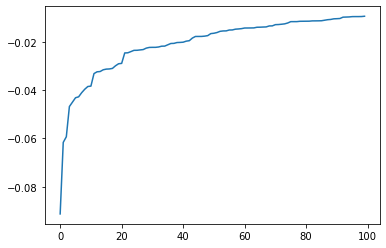

[1.55573565 1.58257009 1.69781713 1.85930591 1.9185886  2.05401846
 2.1316487  2.26028099 2.62089595 3.46466089]


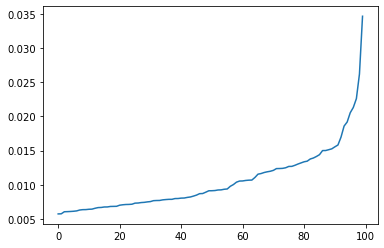

[ 766 1317 1339  603  217  167 1511 1361  728  773  885  816 1037  704
  478  157   40 1054 1018  531]
[ 589  631  793  683  193 1485  652  420  895  243   26  378 1215 1521
  695  353  103 1239  814  417]
6.76958e-05 0.25242934


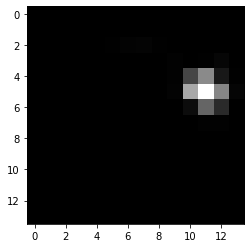

56 mse 0.0484902410693006 0.04656635675406007 -3.9675701188843044


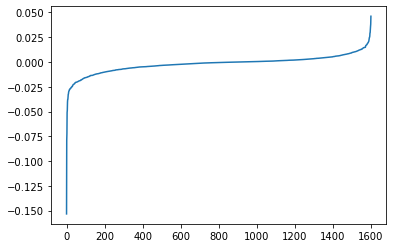

[-15.33144758  -7.90073509  -7.19962456  -5.10744921  -4.87858022
  -4.05267224  -3.78413804  -3.76256259  -3.5140435   -3.26466564]


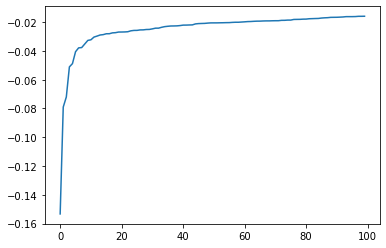

[2.31068538 2.4690972  2.49679206 2.59700637 2.92303974 2.94658523
 3.31866032 3.56297727 3.80434901 4.61341517]


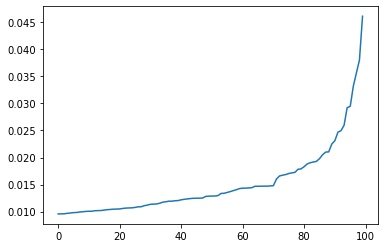

[ 683  958  895 1583  909  486 1368 1107  432  364  279 1238  472  110
  640  971  346  206 1049 1546]
[ 724  339  129 1172  146  309  236 1050  164 1494  359 1191  694   30
  924  763   12 1379 1574  801]
7.704771e-05 0.49834082


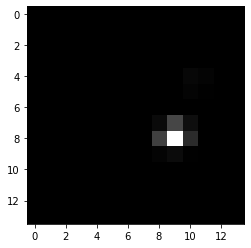

10 mse 0.04230226456664143 0.040439578608440774 -4.403277170342138


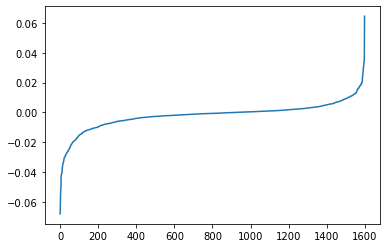

[-6.81679431 -6.07193973 -5.56185062 -5.19555897 -5.1495965  -4.28204767
 -4.19637454 -4.12914531 -4.10382974 -4.09832957]


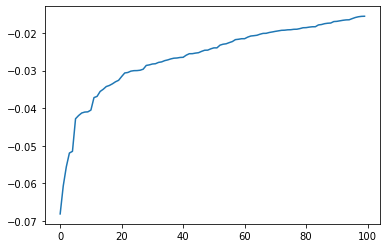

[2.57219829 2.65949493 2.78675231 2.96571778 3.12473255 3.15705987
 3.36450665 3.43885678 3.65407043 6.44554233]


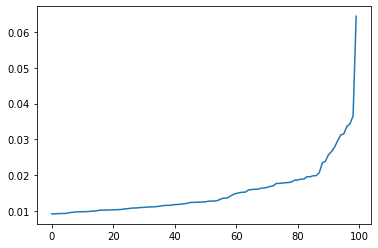

[1246  866  475 1381  506  765 1079 1579  900 1306  479  304   65 1275
  772  379  212  418  892  400]
[1388  216 1144  131  997  154  965 1225  845  469  205 1451 1587  179
   23 1151  240  535  429  914]
0.0010624479 0.056915045


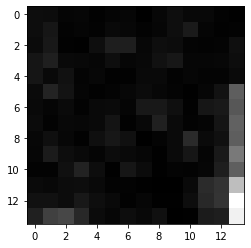

71 mse 0.6970113033041233 0.6817333908839205 -2.1919174549651013


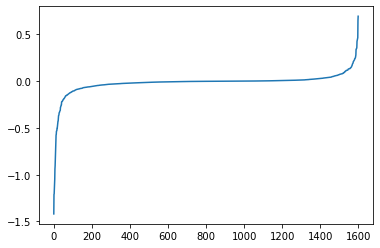

[-141.95871548 -121.17133834 -120.45837031 -115.55452421 -110.44363361
 -104.78919799  -93.89305003  -90.58043666  -83.27175004  -73.76278848]


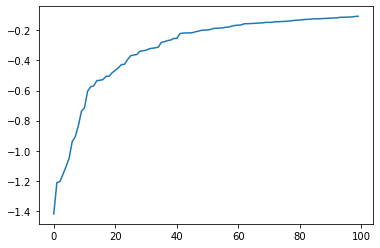

[34.60470395 35.12781589 36.18030699 42.60214774 43.7462485  44.55727826
 45.92747668 46.59400801 64.87087072 69.49364546]


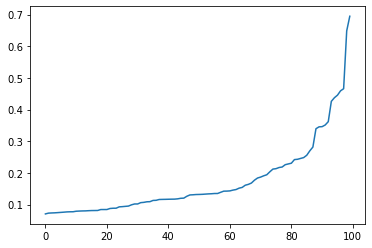

[ 657  274  291  884 1093 1332  225 1247 1502  590  231  603  601 1001
  176  529 1537  289 1223 1243]
[ 669 1066  203  335 1391 1302 1446  718 1107  985  989 1111  761 1065
  849 1387 1110 1175 1479 1541]
6.280133e-05 0.26093712


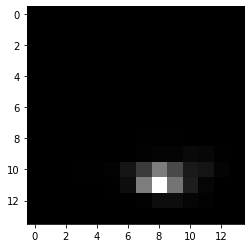

7 mse 0.046027555298737255 0.04411429971463613 -4.156761252435263


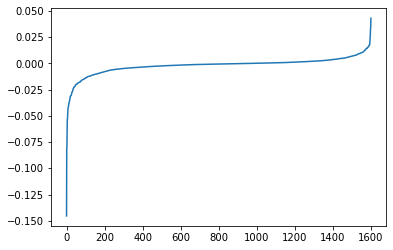

[-14.53728906  -8.0983488   -7.9181683   -6.743441    -5.31895213
  -5.26805795  -4.82507862  -4.45186535  -4.23675037  -4.16402511]


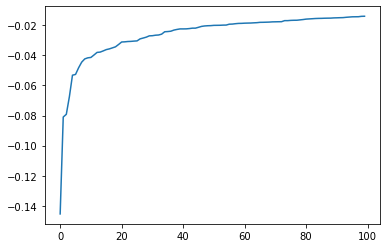

[1.74406427 1.75432013 1.76619575 1.8917311  2.14195783 2.29664615
 2.76997868 3.34646309 3.46986383 4.31406808]


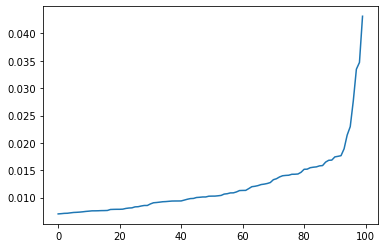

[ 280  292 1438  197  164 1544 1413 1421  996  848 1444 1426 1135 1452
 1000  106 1467  623  577  361]
[ 980  483 1301  218  144  601   65  997  775  124  357  944  467 1416
  572  592 1309  973  710 1490]
8.606591e-05 0.34012675


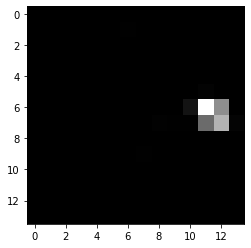

25 mse 0.05517895082862137 0.05359167333053797 -2.876599634910196


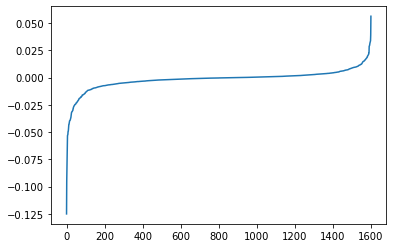

[-12.51339558  -9.49439719  -8.38632958  -7.39329387  -6.31210958
  -5.33022601  -5.27256161  -5.21689025  -4.95647269  -4.93076118]


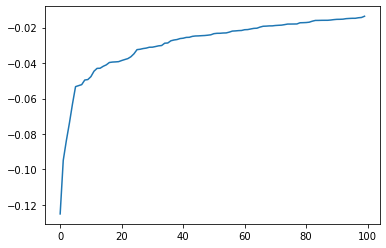

[2.87354582 2.91796923 2.9541695  3.09524524 3.17312556 3.25512071
 3.30251245 3.37968025 3.89868093 5.63269849]


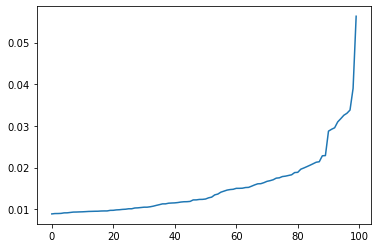

[ 751  642  535  126 1214  702 1407  109  307  492  654  998  662   62
 1026   13  394  600  146  355]
[ 290 1115 1009  664 1233  399  207  999   38 1081  786 1235 1128 1151
 1426 1500 1282 1295  676 1116]


In [26]:
result_dict_1to2 = study_specific_neurons(1,2)

In [27]:
# interesting, there is a big overlap between best improving images from 1-2 and best from 2-4.
set(result_dict_1to2[(0,3)]['img_arg_sort'][:20])& set(result_dict_2to4[(0,3)]['img_arg_sort'][:20])

{42, 98, 141, 156, 211, 648, 668, 728, 767, 798, 824, 942, 1348, 1389, 1502}

In [28]:
set(result_dict_1to2[(1,78)]['img_arg_sort'][:20])& set(result_dict_2to4[(1,78)]['img_arg_sort'][:20])

{289, 529, 607, 806, 878, 942, 1065, 1142, 1179, 1339, 1371}

In [29]:
set(result_dict_1to2[(0,3)]['img_arg_sort'][-20:])& set(result_dict_2to4[(0,3)]['img_arg_sort'][-20:])

{106, 319, 554, 1045, 1288, 1373, 1419, 1582}

In [30]:
# interesting. having more parameters can be consistently bad as well
set(result_dict_1to2[(1,78)]['img_arg_sort'][-20:])& set(result_dict_2to4[(1,78)]['img_arg_sort'][-20:])

{136, 303, 610, 763, 966, 1026, 1076, 1172}

In [31]:
# ok. check these images. rember we need to convert back to original indicies in the 8K set.

In [32]:
def compute_center(w_vec):
#     print(w_vec)
    a = 0
    for z, w in zip(range(14), w_vec):
#         print(z,w)
        a += z*w
#     print(a, sum(w_vec))
    a /= sum(w_vec)
    ret = a/14*50
#     print(ret)
    return int(round(ret))
    

In [33]:
import torchvision
from torch import tensor

In [34]:
# response is response on test.
def show_images(internal_index, responses, title, mask_this):
    indices = get_indices('a', 'legacy')
    assert len(indices) == 3
    test_images_idx = indices[2]
    assert test_images_idx.shape == (1600,)
    
    external_idx = test_images_idx[internal_index]
    responses_this = responses[internal_index]
    
    
    
    print(title)
    print(external_idx, responses_this)
    
    
    
    # show external images at locations indicated by the mask.
    
    # load images.
    data_gt = get_data('a', 200, 50,
             ('042318', '043018', '051018'),
             scale=0.5,
             seed='legacy')[4]
    
    # first, calculate weighted center of the mask.
    assert mask_this.shape == (14,14)
    
    mask_weight_center_horizontal = compute_center(mask_this.sum(axis=0))
    mask_weight_center_vertical = compute_center(mask_this.sum(axis=1))
    
    axis0slice = slice(mask_weight_center_vertical-8, mask_weight_center_vertical+8)
    axis1slice = slice(mask_weight_center_horizontal-8, mask_weight_center_horizontal+8)
    
    print('center', axis0slice, axis1slice)
    
    plt.close('all')
    print(mask_this.min(), mask_this.max())
    plt.imshow(mask_this, cmap='gray',
               vmin = mask_this.min(),
               vmax = mask_this.max())
    plt.show()
    print(data_gt.min(),data_gt.max())
    assert data_gt.shape == (1600, 1, 50, 50)
    data_gt = data_gt/255.0
    images_to_show = data_gt[internal_index]
    images_to_show_focus = data_gt[internal_index,:,axis0slice,axis1slice]
    print(images_to_show_focus.shape)
    
    
    plt.close('all')
    plt.figure(figsize=(16, 10))
    plt.imshow(
        torchvision.utils.make_grid(tensor(images_to_show), nrow=10, range=(0.0,1.0)).permute(1, 2, 0),
    )
    plt.show()
    
    
    plt.close('all')
    plt.figure(figsize=(16, 10))
    plt.imshow(
        torchvision.utils.make_grid(tensor(images_to_show_focus), nrow=10, range=(0.0,1.0)).permute(1, 2, 0),
    )
    plt.show()
    # then use pytorch's stuff to show

def playaround():
    neuron_list = [3, 78, 28, 53, 24, 56, 10, 71,  7, 25]
    gt = load_gt(neuron_list)
    
    print(gt.shape)
    
    for n_idx_idx, n_idx in enumerate(neuron_list):
        print(n_idx_idx, n_idx)
        responses = gt[:, n_idx_idx]
#         print(responses.mean(), responses.std())
        top_imgs = np.argsort(responses)[::-1][:20]
        worst_imgs = np.argsort(responses)[::-1][-20:]
        
#         worst_improved = set(result_dict_1to2[n_idx_idx, n_idx]['img_arg_sort'][-20:]) & set(result_dict_2to4[n_idx_idx, n_idx]['img_arg_sort'][-20:])
        worst_improved = set(result_dict_2to4[n_idx_idx, n_idx]['img_arg_sort'][-20:])
#         top_improved = set(result_dict_1to2[n_idx_idx, n_idx]['img_arg_sort'][:20]) & set(result_dict_2to4[n_idx_idx, n_idx]['img_arg_sort'][:20])
        top_improved = set(result_dict_2to4[n_idx_idx, n_idx]['img_arg_sort'][:20])
        print(len(worst_improved), len(top_improved))
        # not corelated.
        
#         print(set(top_imgs) & worst_improved)
#         print(set(worst_imgs) & worst_improved)
#         print(set(top_imgs) & top_improved)
#         print(set(worst_imgs) & top_improved)
        
        
        indices = get_indices('a', 'legacy')
        assert len(indices) == 3
        test_images_idx = indices[2]
        assert test_images_idx.shape == (1600,)
        
        worst_improved = list(worst_improved)
        top_improved = list(top_improved)
        
        mask_this = result_dict_1to2[n_idx_idx, n_idx]['rf_map']
        
        show_images(worst_improved, responses, 'worst', mask_this)
        show_images(top_improved, responses, 'top', mask_this)
        show_images(top_imgs, responses, 'high',mask_this)
        
        

(1600, 10)
0 3
20 20
worst
[3763  665 6229 7023  102 5092  784  139 2759  181 2813 7892 2243 7895
 5231 1623 1650 2919 6733  555] [0.52166923 0.71430566 0.65213245 0.55653134 0.37627422 0.39419302
 0.32618779 0.35890009 0.52548276 0.68069645 0.38001071 0.58484116
 0.41419826 0.44879944 0.29519256 0.61583616 0.23515445 0.15652045
 0.37965761 0.53273098]
center slice(18, 34, None) slice(37, 53, None)
6.489781e-05 0.3157065


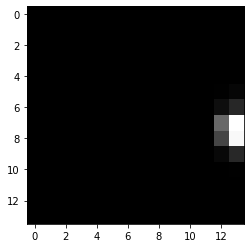

0.0 255.0
(20, 1, 16, 13)


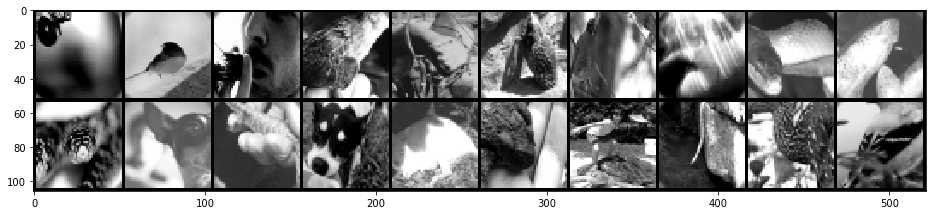

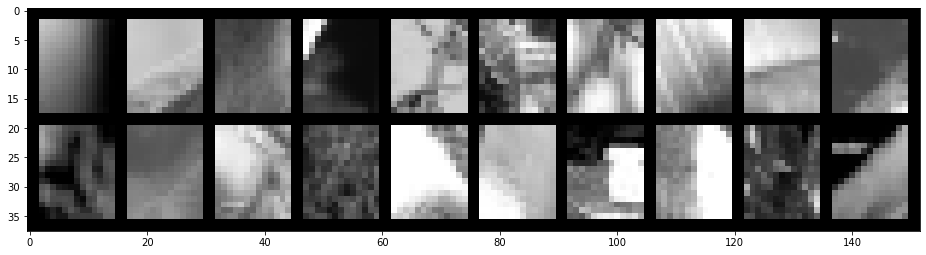

top
[3188  710 7749 5099  795 3279 3892  226 4605  889 4033 6613 3512 1067
 3574 7494  506 6853 3152 3751] [0.16529576 0.16540484 0.73001466 0.76161287 0.23261467 0.18199695
 0.21539445 0.17356699 0.14279064 0.284392   0.16071729 0.14022542
 0.72712855 0.12941819 0.12275063 0.20314605 0.22515438 0.18067658
 0.24553716 0.12680303]
center slice(18, 34, None) slice(37, 53, None)
6.489781e-05 0.3157065


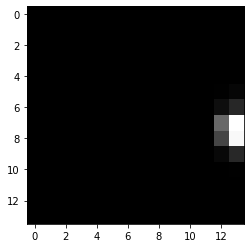

0.0 255.0
(20, 1, 16, 13)


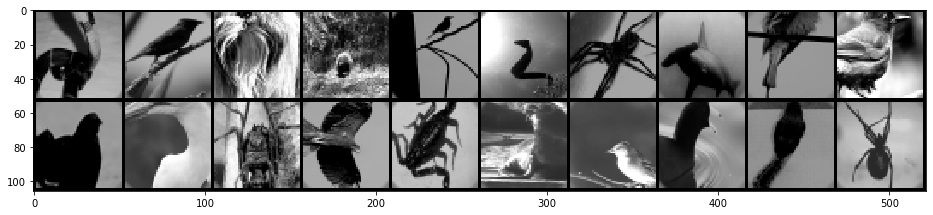

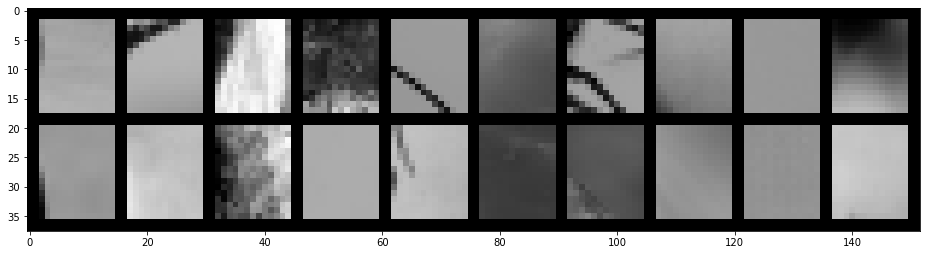

high
[1215 4656 3334 3724 4456 5571 1287 3766 1250 7584 5099 5596 7238 1316
 4056 6088  882 3057 7076 1267] [0.79569139 0.79011626 0.78461252 0.77881038 0.7772703  0.77005846
 0.76946882 0.76937422 0.76324654 0.76249182 0.76161287 0.75300995
 0.75208888 0.75014269 0.74593152 0.74317993 0.73841107 0.7379378
 0.73676536 0.73632675]
center slice(18, 34, None) slice(37, 53, None)
6.489781e-05 0.3157065


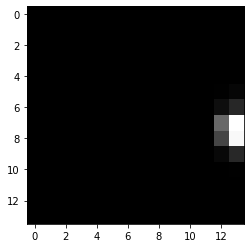

0.0 255.0
(20, 1, 16, 13)


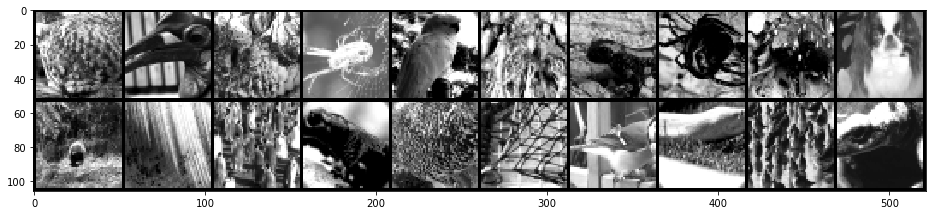

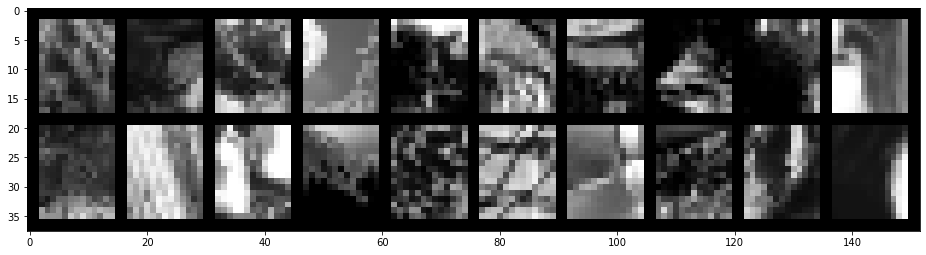

1 78
20 20
worst
[5007 2029 2657  680 7747 5656 1517 1523  867 1555  274 7911 5242 4734
 6634 3050  587 4275 7615 3741] [0.91357437 0.19580719 0.9792943  0.62562872 0.07728178 0.22388535
 0.9111291  0.28971149 0.88990515 0.72564937 0.98032661 0.27597052
 0.22847769 0.61442639 0.29747843 0.96462213 0.86381923 0.25434422
 0.96795052 0.69694129]
center slice(9, 25, None) slice(31, 47, None)
6.469276e-05 0.2450698


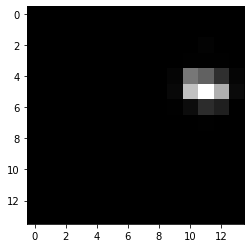

0.0 255.0
(20, 1, 16, 16)


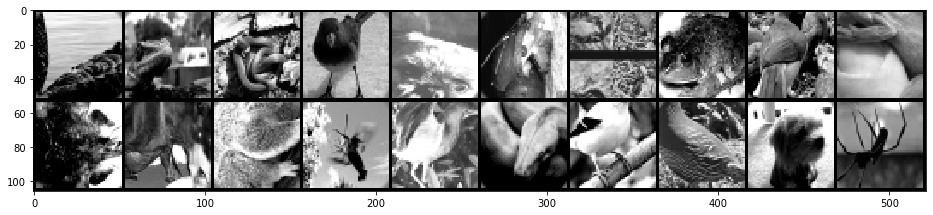

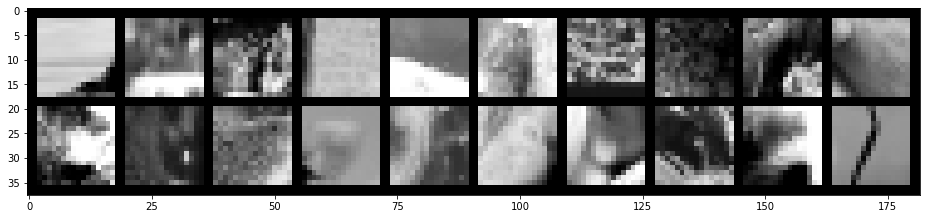

top
[  71 2693 5688 1465 3948 5203 4605 6575 7403 6662 5429 6728 3041 4257
 6901 5540 4281 2596 6955 4326] [0.34066227 0.13493169 0.15983812 0.17295847 0.03793725 0.02828109
 0.16047664 0.35133914 0.94683872 0.89011888 0.81214385 0.10556287
 1.16492754 0.0777816  0.82598169 0.11501222 0.46341494 1.04811825
 0.25555241 0.36782139]
center slice(9, 25, None) slice(31, 47, None)
6.469276e-05 0.2450698


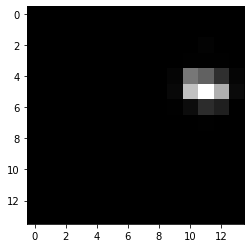

0.0 255.0
(20, 1, 16, 16)


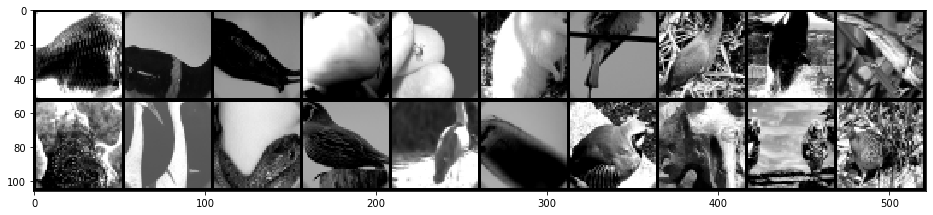

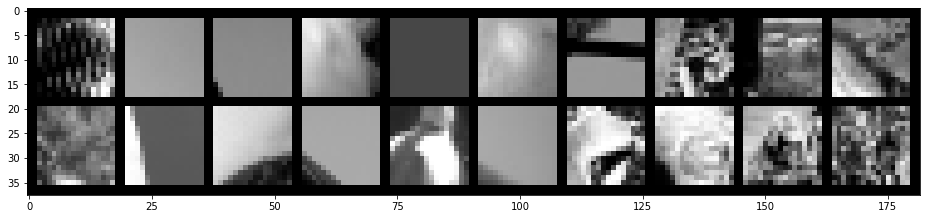

high
[3041 4131 6463 2624 2596 5871 2757  274 2657 5456 7615 3050 1956 6266
 7403 3211 5680 4794 6111 6632] [1.16492754 1.07396174 1.0711152  1.06815241 1.04811825 1.02538988
 1.01086515 0.98032661 0.9792943  0.97833051 0.96795052 0.96462213
 0.96060617 0.95569122 0.94683872 0.94617015 0.94550431 0.94483781
 0.93877503 0.93424885]
center slice(9, 25, None) slice(31, 47, None)
6.469276e-05 0.2450698


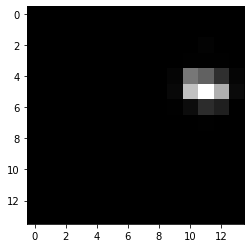

0.0 255.0
(20, 1, 16, 16)


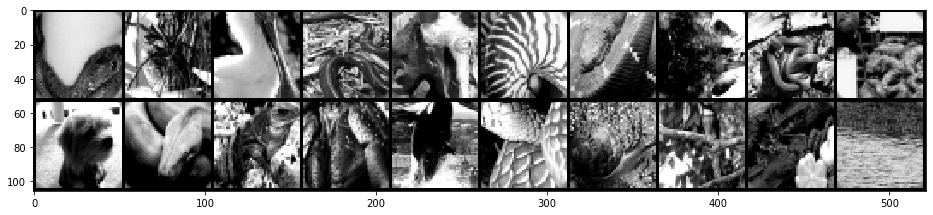

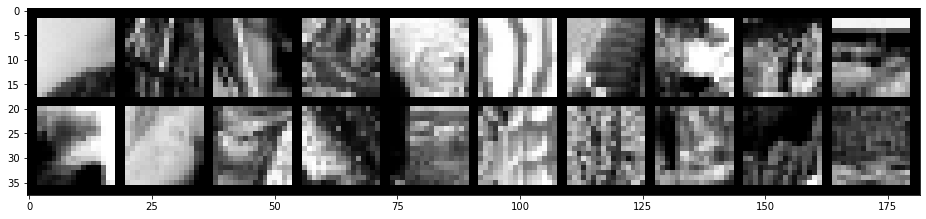

2 28
20 20
worst
[3758   13 5582  102 7793 7808  197  827 5786 5213 1548 5820 4657 7294
 4708 1650 4131 3571 1896 5568] [1.02885413 0.7945014  0.17321636 0.14515832 1.32430295 0.28460321
 0.3055403  0.26147336 0.26063636 0.08320862 1.16798282 0.30059892
 0.36632973 0.63353765 0.5606595  0.04512774 0.34872005 1.3887735
 1.05727005 1.13627152]
center slice(18, 34, None) slice(37, 53, None)
8.4911844e-05 0.30630425


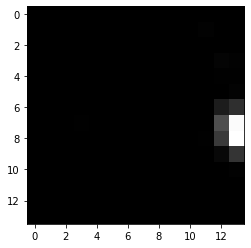

0.0 255.0
(20, 1, 16, 13)


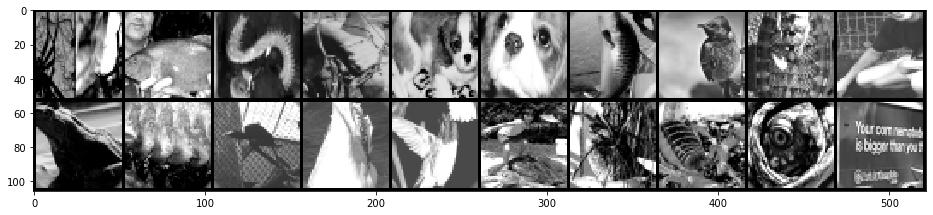

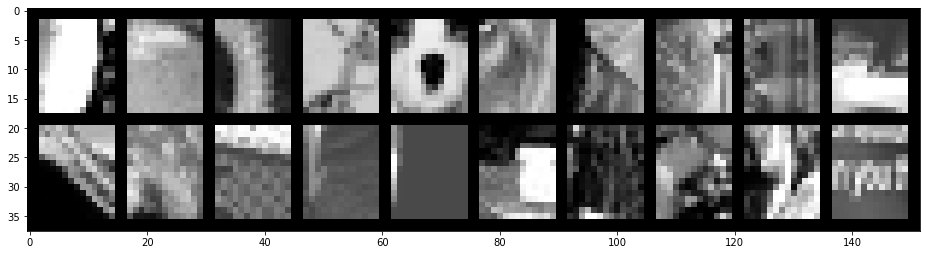

top
[4332 6294 2110 4504 3290 6402 5210 5807 3370 6464  898 7257 3455 2307
 3601 4845 6095 6896 4266 3726] [1.04582335 1.34509764 1.17010301 1.26690682 1.19127802 0.25777227
 1.09247769 1.31509085 1.30922838 0.19378144 0.31807156 1.39030469
 0.1553201  1.2065307  1.47672545 1.06735936 0.33416012 1.40096273
 0.48872725 1.36076183]
center slice(18, 34, None) slice(37, 53, None)
8.4911844e-05 0.30630425


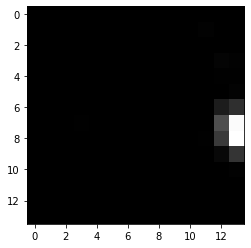

0.0 255.0
(20, 1, 16, 13)


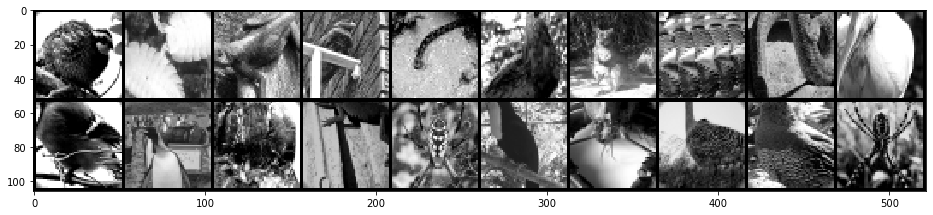

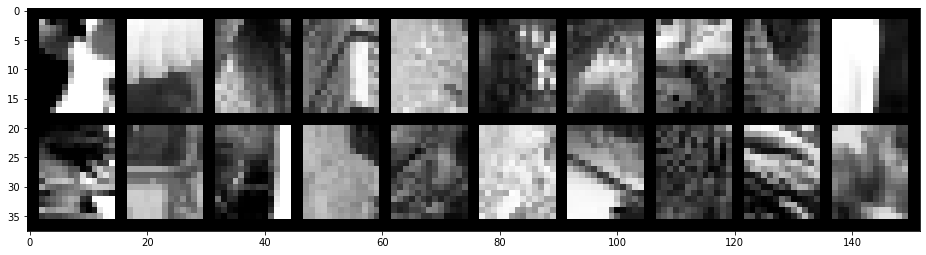

high
[3601 1759 6896 7257 3571 3304 3726 1224 6294  691 6746 7793 5807 3370
 6662 4193 2807 2896 4504 3597] [1.47672545 1.44005365 1.40096273 1.39030469 1.3887735  1.36552267
 1.36076183 1.35438566 1.34509764 1.33341715 1.32895974 1.32430295
 1.31509085 1.30922838 1.29652177 1.28355707 1.2807669  1.27605414
 1.26690682 1.25990605]
center slice(18, 34, None) slice(37, 53, None)
8.4911844e-05 0.30630425


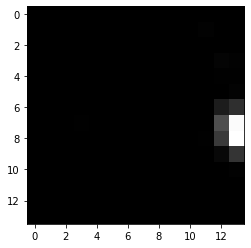

0.0 255.0
(20, 1, 16, 13)


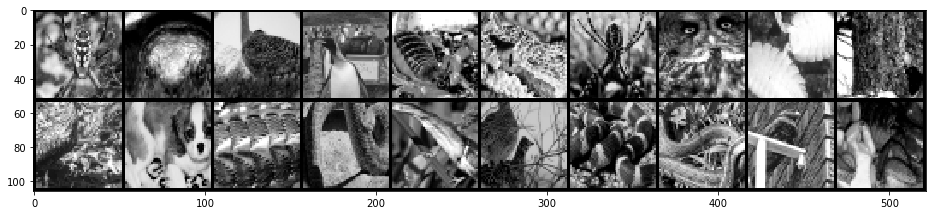

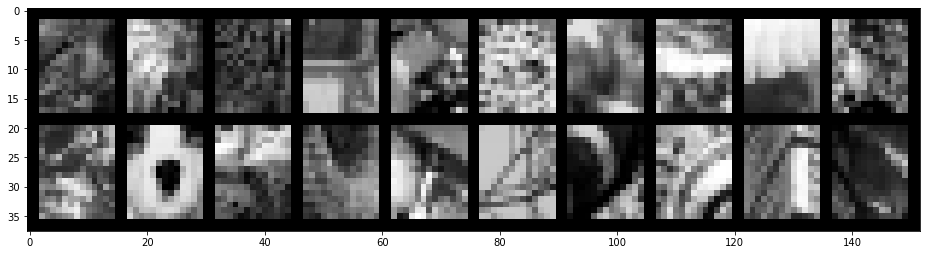

3 53
20 20
worst
[1326 1359 4430  730 5088 4479  794 6345 6406 4572 6463 2255 6557 5287
 1637 4725  993 7403 4183 2571] [0.22849246 0.9660731  0.36196729 0.78285573 1.13353981 0.22771216
 0.82152156 0.22942001 0.84573601 0.27749148 0.90956902 1.01202938
 0.89085568 0.31986974 0.3481035  0.92626664 0.38713463 0.31055543
 0.70160821 0.75100052]
center slice(10, 26, None) slice(29, 45, None)
5.3480846e-05 0.2715168


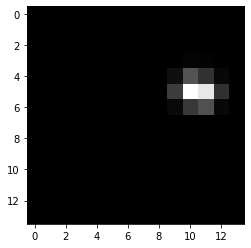

0.0 255.0
(20, 1, 16, 16)


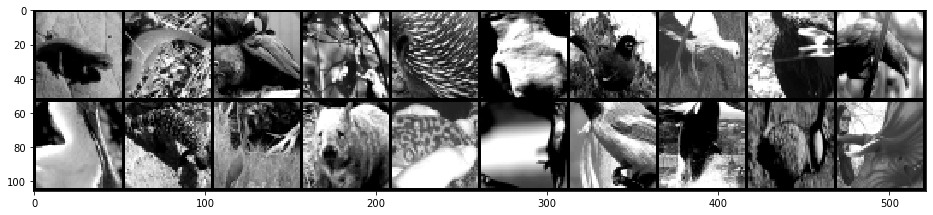

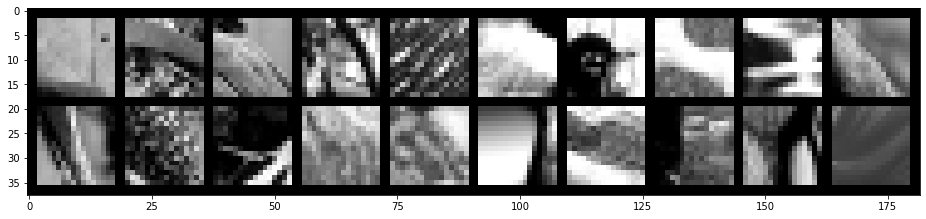

top
[4411 3820 5671 3279 2789  827 3350 4605 4004 2849 2856 4775 5429 5448
 7502 2480 2482 3128 4281 3734] [0.46101555 0.26020412 0.43122273 0.18704808 0.89242338 0.86109983
 0.33284279 0.12797928 0.13515844 0.90279236 1.02052794 0.46021737
 0.89430673 0.30321818 0.85588013 0.43953339 0.4595194  0.35916616
 0.60964447 0.13874229]
center slice(10, 26, None) slice(29, 45, None)
5.3480846e-05 0.2715168


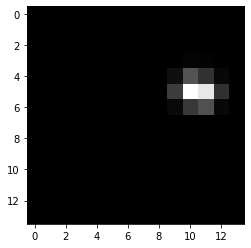

0.0 255.0
(20, 1, 16, 16)


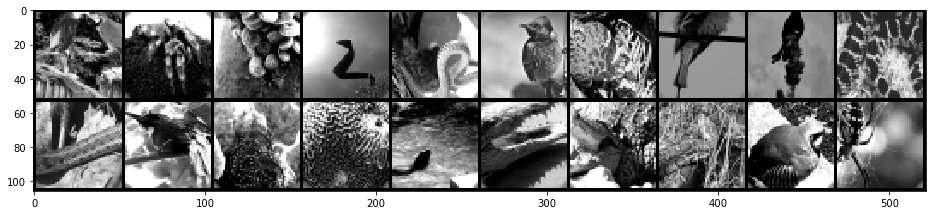

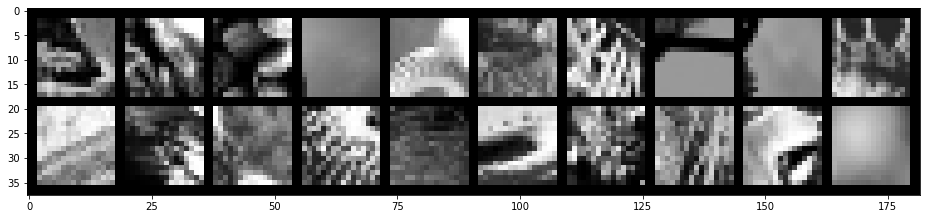

high
[5088 6632 3370 2856 7961 3782 2255 2869 5940 5455 6551 1359 4213 3821
 1733 1303 5251 3001  623 4725] [1.13353981 1.07460317 1.02915023 1.02052794 1.02007488 1.01664405
 1.01202938 0.99173694 0.98935041 0.98435337 0.96715081 0.9660731
 0.9630608  0.9623417  0.94264976 0.93480081 0.93192718 0.93159837
 0.92890607 0.92626664]
center slice(10, 26, None) slice(29, 45, None)
5.3480846e-05 0.2715168


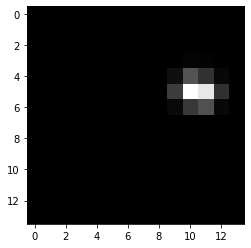

0.0 255.0
(20, 1, 16, 16)


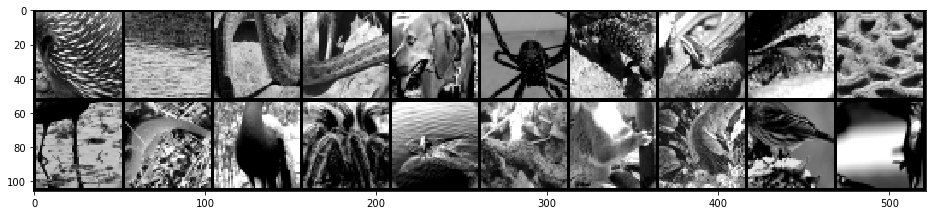

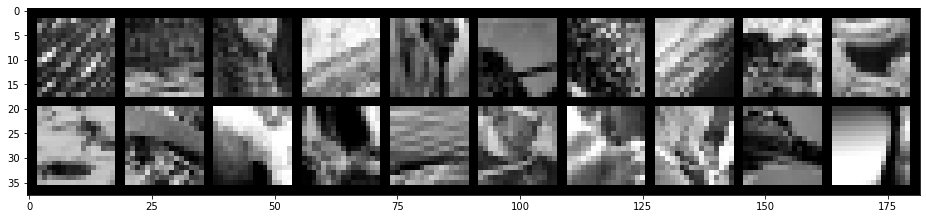

4 24
20 20
worst
[5070 2713 5680 3869 2159 5786 3350 3994  889  275 2850 2876 2896 7393
 4183 5977 7584 4897 5568 4326] [0.98009174 0.86800572 1.61828395 0.94724203 0.44974745 0.90317778
 1.23377516 1.34216304 0.80965482 1.06457594 1.32439383 1.11572341
 1.14751494 1.52043152 1.25355719 1.23757651 0.46631092 1.09442363
 0.85590596 1.03282543]
center slice(13, 29, None) slice(30, 46, None)
6.674334e-05 0.4055041


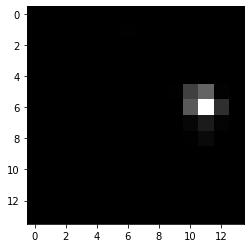

0.0 255.0
(20, 1, 16, 16)


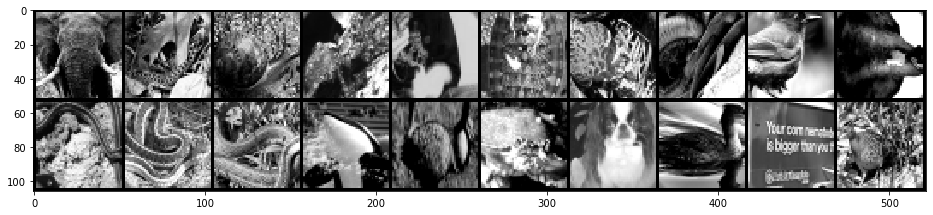

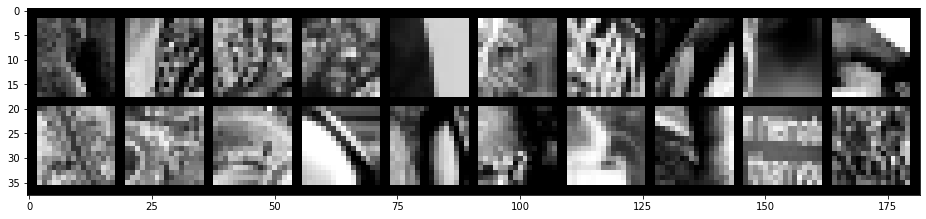

top
[5060 5079 2698 5137 6391  841  211 3964 5853 6575 7294 4725 5930 5401
 3574 1087 3032  581 1896 3750] [0.9371359  0.65123849 1.1332953  1.04568381 1.36678383 1.17776379
 1.17358305 0.84608526 0.83185477 0.70940336 0.93067604 0.98139426
 1.0277436  1.11603153 1.00277365 1.04694008 1.11193545 1.00815259
 0.61135626 1.38399828]
center slice(13, 29, None) slice(30, 46, None)
6.674334e-05 0.4055041


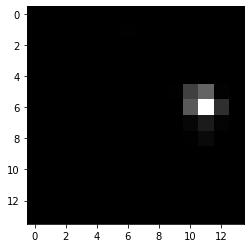

0.0 255.0
(20, 1, 16, 16)


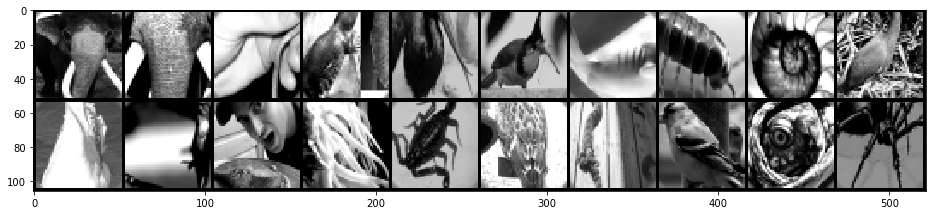

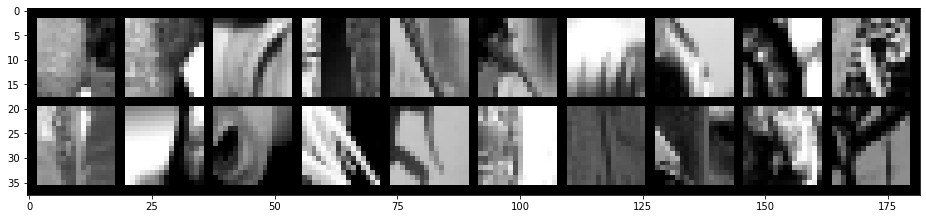

high
[5680 7548 2647 7393  824 6670 3750 6391  499 5643 3994 2850 1524 4578
 6660 4272 4183 6140 5977 3350] [1.61828395 1.5969505  1.56399546 1.52043152 1.44332044 1.38785581
 1.38399828 1.36678383 1.36436598 1.36404065 1.34216304 1.32439383
 1.32316262 1.30983069 1.29658284 1.29254051 1.25355719 1.23769238
 1.23757651 1.23377516]
center slice(13, 29, None) slice(30, 46, None)
6.674334e-05 0.4055041


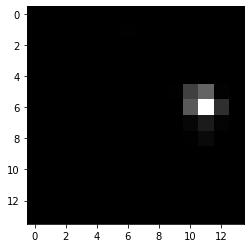

0.0 255.0
(20, 1, 16, 16)


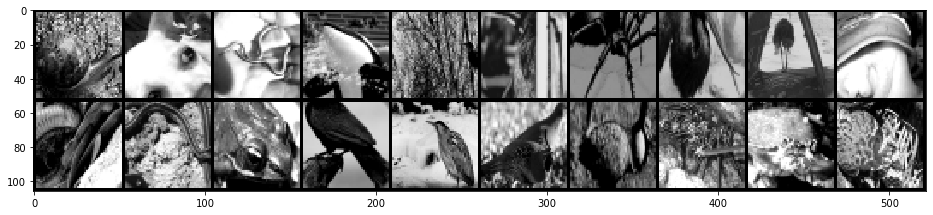

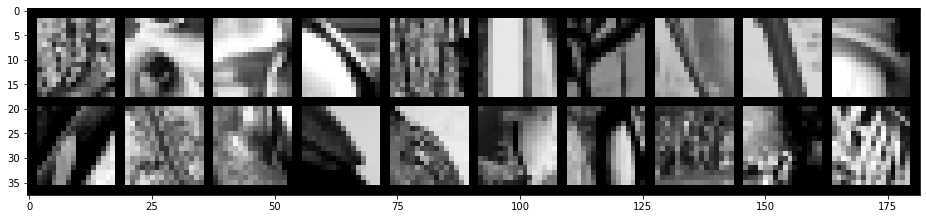

5 56
20 20
worst
[3163   71  730 5656 2113  161 3906  827 7827 4597 1577 4056 2300 1725
 4775 7442 2421 1204 3741 6955] [1.17071708 1.22212409 0.93838848 0.31725958 1.32516268 0.80466643
 1.42941732 0.29015077 0.15586117 1.1003001  0.21683217 1.2416074
 0.83462635 0.07657167 1.02630987 0.55177525 1.15499351 0.27833972
 0.97102684 1.23345642]
center slice(10, 26, None) slice(31, 47, None)
6.76958e-05 0.25242934


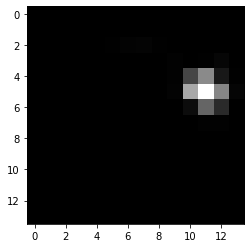

0.0 255.0
(20, 1, 16, 16)


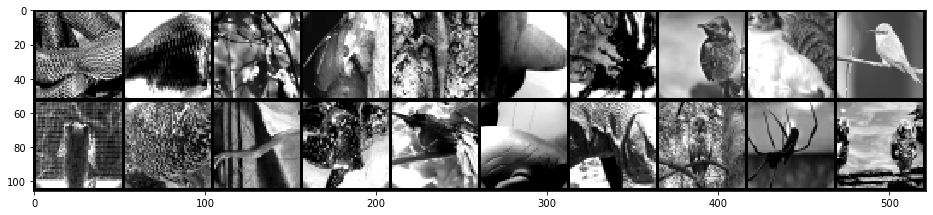

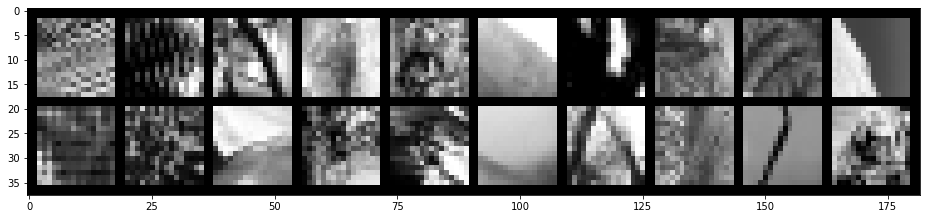

top
[4419 5105 5117 3350 7895 2244 2255 4009 4703 5885 7351 7376 5401 6708
 2417 2482 3128 1850 4281 4326] [1.20291126 0.36082364 0.34486454 0.55031103 1.18802861 1.05111183
 0.47860013 0.17287559 1.41776687 1.05793938 1.25542299 1.27809237
 0.43147041 0.99433343 1.05849892 0.41809793 0.37023623 1.11115901
 0.31901778 0.36193257]
center slice(10, 26, None) slice(31, 47, None)
6.76958e-05 0.25242934


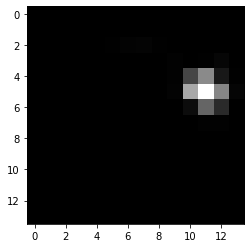

0.0 255.0
(20, 1, 16, 16)


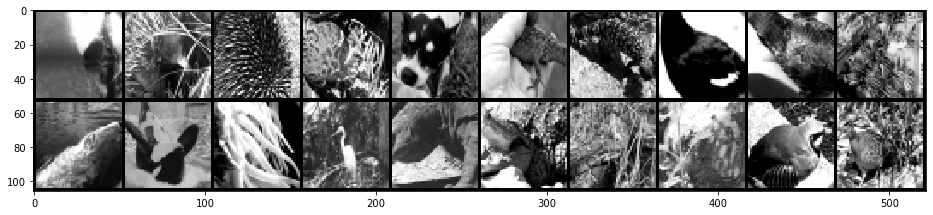

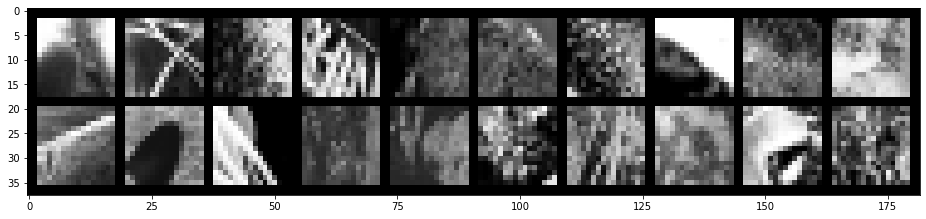

high
[7710 3906 4334 4703 3158 6082 2194 2113 7250 7988 3820 5451 4657 7376
 7351 5940 5012 4056 1887 6955] [1.57800587 1.42941732 1.42741191 1.41776687 1.39656275 1.34291881
 1.34223655 1.32516268 1.32378829 1.29870149 1.29517957 1.28001373
 1.27933064 1.27809237 1.25542299 1.25471004 1.24577292 1.2416074
 1.23691943 1.23345642]
center slice(10, 26, None) slice(31, 47, None)
6.76958e-05 0.25242934


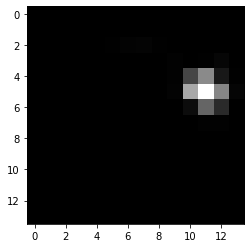

0.0 255.0
(20, 1, 16, 16)


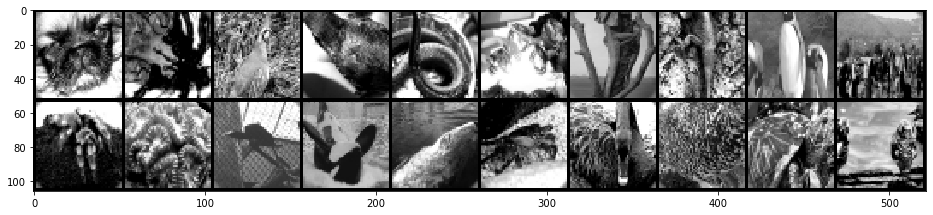

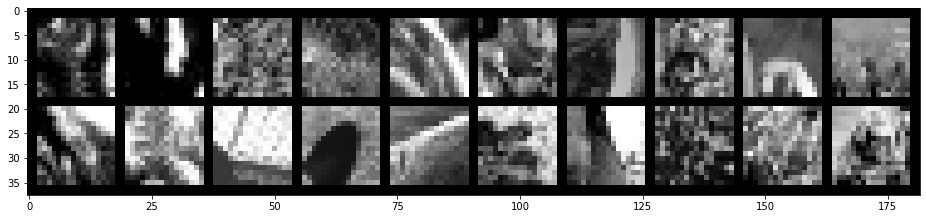

6 10
20 20
worst
[3758 6175 4439 4456 2713  772 5730 3924 7195  291 5846 2919 2377 2383
 2411 6750 4851 4887  615 5549] [0.22921886 1.00290603 1.34215688 1.1768319  1.4880827  0.87213727
 1.31948879 1.11429199 0.35905347 0.93438145 0.93646343 0.25411752
 1.10870481 1.18327329 0.31189188 0.22692072 0.91616476 0.53705889
 0.93439537 0.47427831]
center slice(19, 35, None) slice(24, 40, None)
7.704771e-05 0.49834082


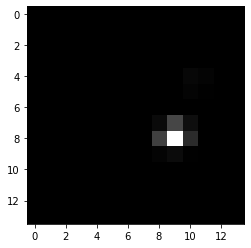

0.0 255.0
(20, 1, 16, 16)


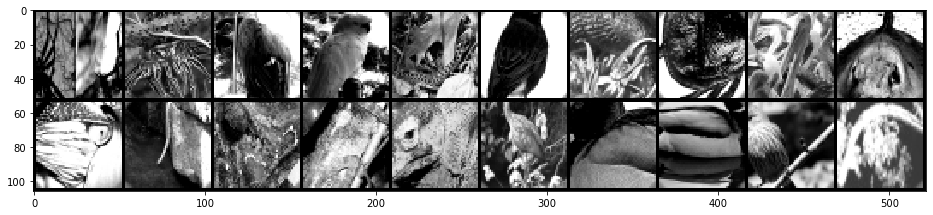

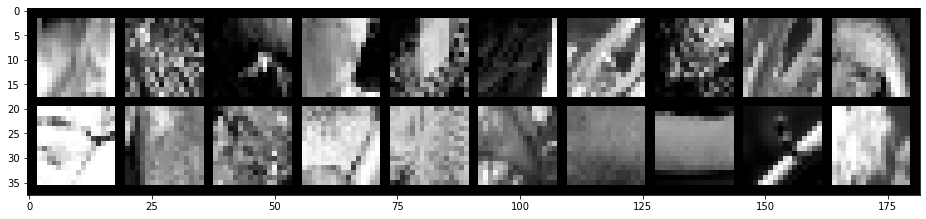

top
[6988 3768 5150 7870 2828 3994 4135 3538  433 5408 2426 6001 4216 6778
  535 4893 6156 4300 4303 3153] [0.45992169 0.73933826 1.00080356 1.24208921 0.38854878 0.67705941
 0.43165691 1.09974897 0.62474008 0.74975687 1.77246317 1.39463686
 1.22150288 1.19223082 0.80281234 1.25885041 1.24498459 1.10919197
 0.70090286 0.15150816]
center slice(19, 35, None) slice(24, 40, None)
7.704771e-05 0.49834082


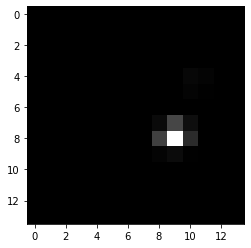

0.0 255.0
(20, 1, 16, 16)


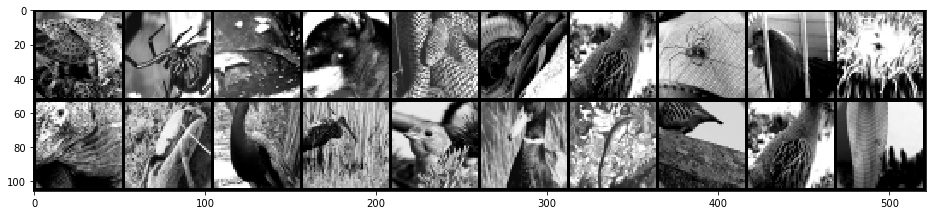

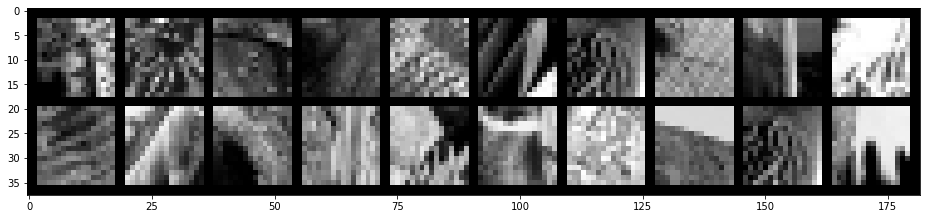

high
[2426 6341 2713 6001 5680 5715 4439 5730 2829 4893 2876 6156 7870 6151
 4216 7793 3361 5927 1956 3624] [1.77246317 1.50347637 1.4880827  1.39463686 1.37992381 1.37109576
 1.34215688 1.31948879 1.29943534 1.25885041 1.25109145 1.24498459
 1.24208921 1.22185233 1.22150288 1.21957306 1.21724474 1.21424255
 1.21353109 1.19326339]
center slice(19, 35, None) slice(24, 40, None)
7.704771e-05 0.49834082


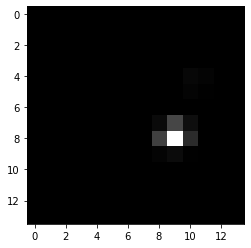

0.0 255.0
(20, 1, 16, 16)


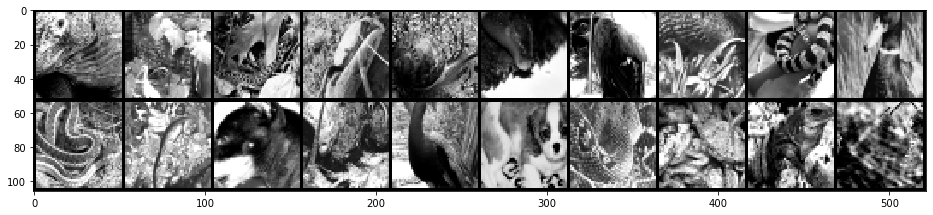

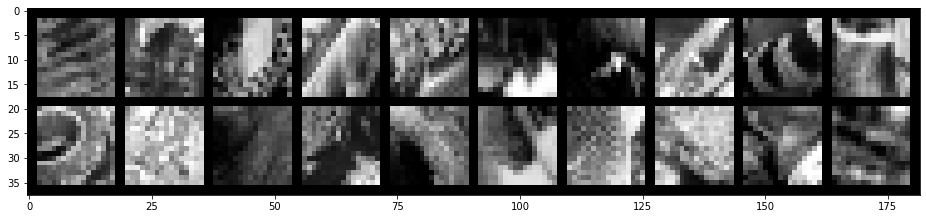

7 71
20 20
worst
[7687 6297 5664 2749 7806 7168 5203 5205 1557 7351 3537 1690 7400 5412
  466 4816 4837 6835 6861 3731] [0.         3.44814384 0.         0.79660963 0.         3.29315682
 0.         0.78166526 1.18019166 0.         3.73949902 3.05194409
 3.59354017 0.         4.08747547 0.         4.99764441 3.03986376
 0.         0.        ]
center slice(20, 36, None) slice(21, 37, None)
0.0010624479 0.056915045


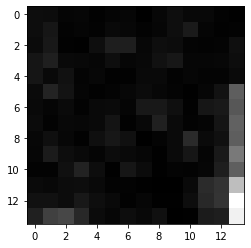

0.0 255.0
(20, 1, 16, 16)


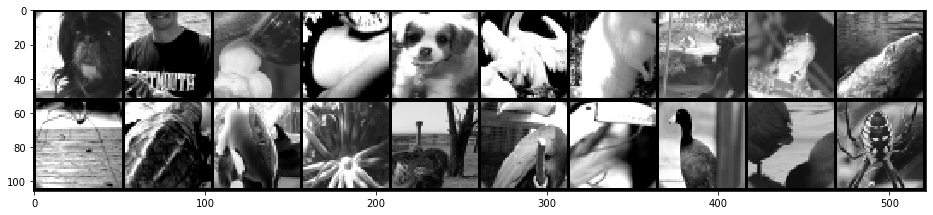

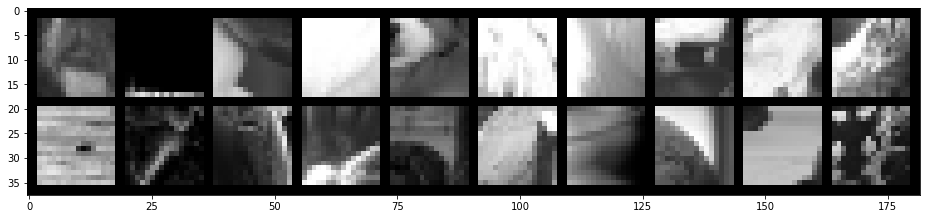

top
[1316 3242 1405 2693 1465 1481  885 6529 5324 1679 2952 3029 5995 3032
 7494 6003 1128 4865 5484 4268] [0.         6.83406505 5.79289492 3.83010799 4.24869092 6.23691443
 3.55043167 4.4155779  5.66138908 0.         4.24086257 2.78224079
 4.12473189 4.34284813 3.45399729 5.33251399 5.12332098 1.11691909
 3.54057499 5.45331051]
center slice(20, 36, None) slice(21, 37, None)
0.0010624479 0.056915045


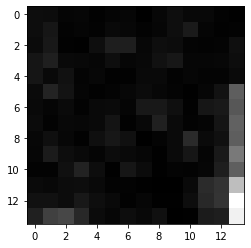

0.0 255.0
(20, 1, 16, 16)


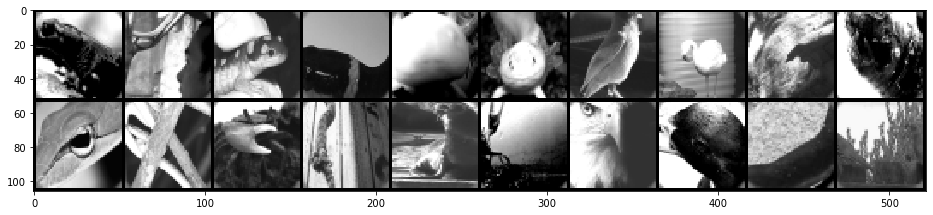

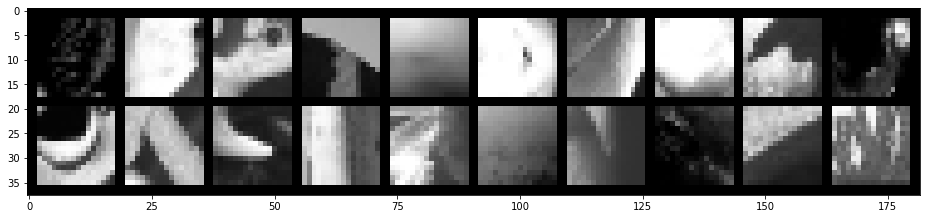

high
[3242 1481 1405 2383 5324 4268 6363 6003 1165 1128 4837 1479 4500 6529
 5628 3032  310 2367 1465 2952] [6.83406505 6.23691443 5.79289492 5.72234596 5.66138908 5.45331051
 5.40180371 5.33251399 5.12837211 5.12332098 4.99764441 4.98581036
 4.47683598 4.4155779  4.374913   4.34284813 4.3158413  4.29706562
 4.24869092 4.24086257]
center slice(20, 36, None) slice(21, 37, None)
0.0010624479 0.056915045


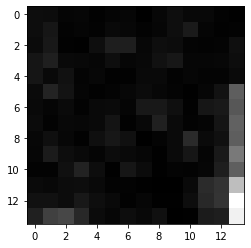

0.0 255.0
(20, 1, 16, 16)


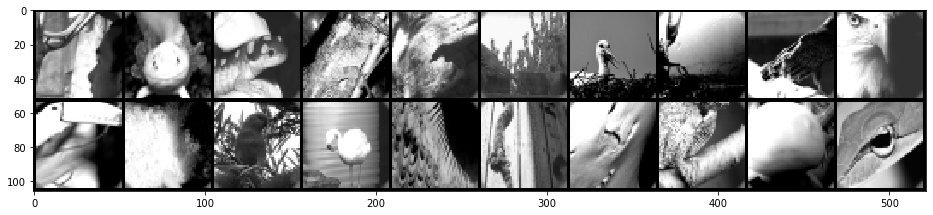

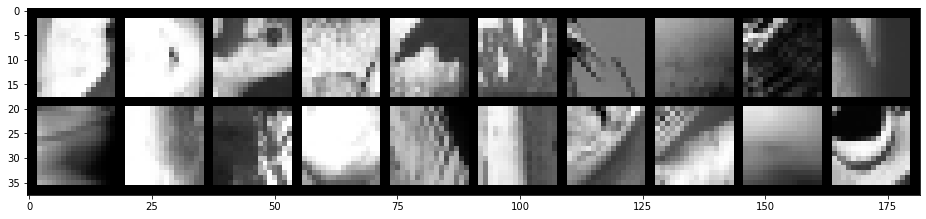

8 7
20 20
worst
[7009 2692 6268  746 7856 5809 4614 6511 2870 2884 3491 7354 2403 5401
 4194 6733 4851 1179 6129 3745] [0.46685082 0.93504788 1.1146153  1.23795937 0.89006407 0.68714254
 0.90649796 0.70109224 1.47870002 1.55485608 0.96715731 0.15046839
 0.20935717 0.1721952  0.62628507 1.30283052 0.4521752  1.18827868
 0.23853814 0.5369335 ]
center slice(30, 46, None) slice(21, 37, None)
6.280133e-05 0.26093712


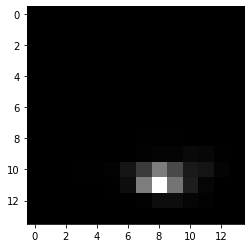

0.0 255.0
(20, 1, 16, 16)


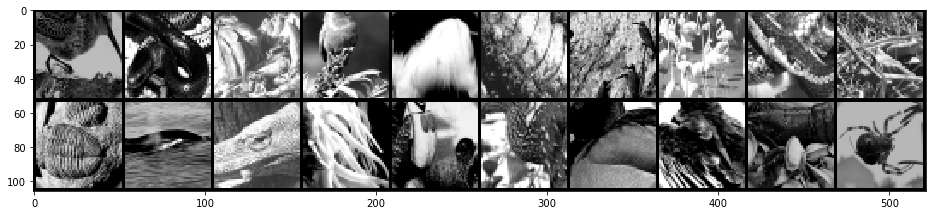

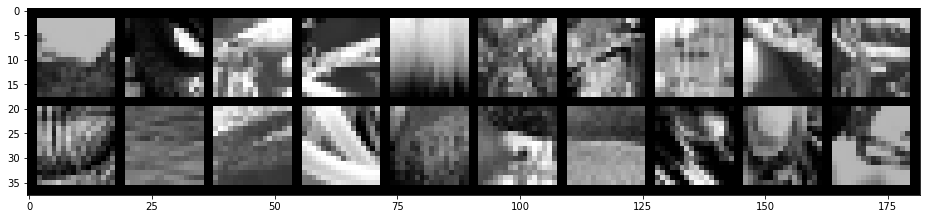

top
[6995   42 7692  734 1428 3882 7145  827 7204 6543 7284  986 5930 4133
  462 4848 3647 1841 3093 7626] [1.16732071 1.1166934  1.11601318 1.14343138 1.65064667 1.39544808
 1.20114433 1.42325759 0.67330899 0.21414791 1.05313123 1.2346568
 0.91565035 0.0359101  0.93961053 1.03099538 1.03654621 1.26240599
 1.41833957 1.45555918]
center slice(30, 46, None) slice(21, 37, None)
6.280133e-05 0.26093712


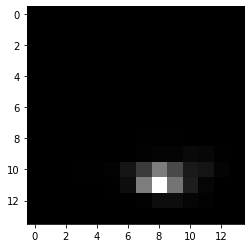

0.0 255.0
(20, 1, 16, 16)


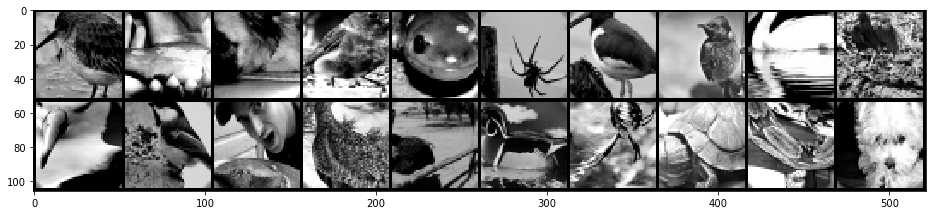

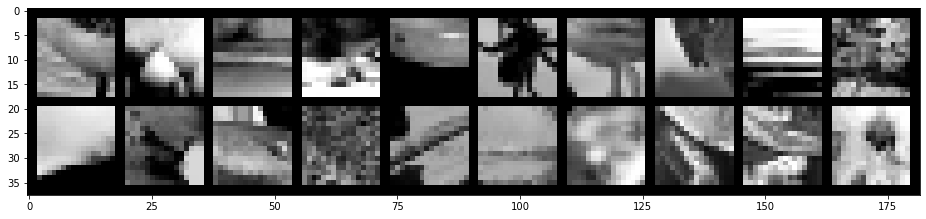

high
[1428 2884 2870 7626 1482  827 3093 3882 1629 2419 4157 5503 6634 7911
  894 6733 7056 5558 1841 5251] [1.65064667 1.55485608 1.47870002 1.45555918 1.43473608 1.42325759
 1.41833957 1.39544808 1.39425415 1.39245155 1.39213269 1.3848142
 1.37320377 1.36770587 1.32245937 1.30283052 1.289351   1.28608667
 1.26240599 1.2612995 ]
center slice(30, 46, None) slice(21, 37, None)
6.280133e-05 0.26093712


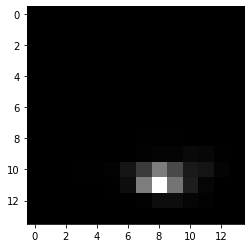

0.0 255.0
(20, 1, 16, 16)


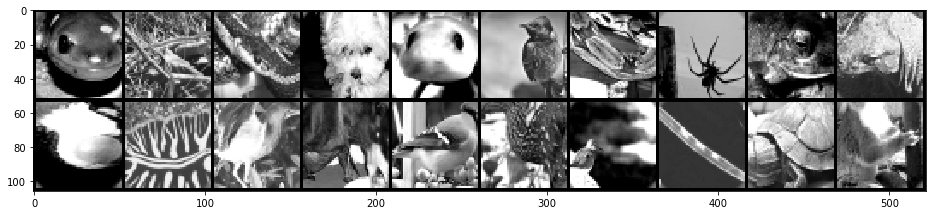

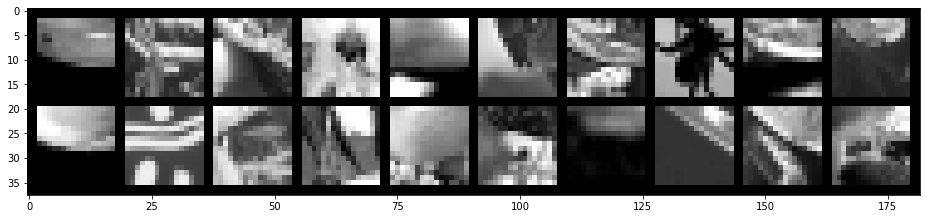

9 25
20 20
worst
[2640 4334 6175 2076 5086 7072 4578 6563 2901 5966 5429 5432 7502 4857
 5473 5475 1874 1887  630 5571] [0.91623515 1.01136913 1.33621982 0.12961296 1.35320848 0.21016192
 1.18790316 1.4065115  1.25390212 1.5943941  1.16192538 1.51403218
 0.34611163 0.27770915 0.22174823 1.14811444 0.38124778 1.35107439
 1.20051102 0.34402418]
center slice(15, 31, None) slice(32, 48, None)
8.606591e-05 0.34012675


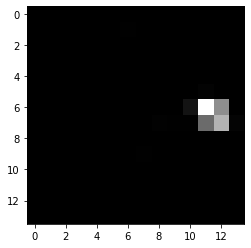

0.0 255.0
(20, 1, 16, 16)


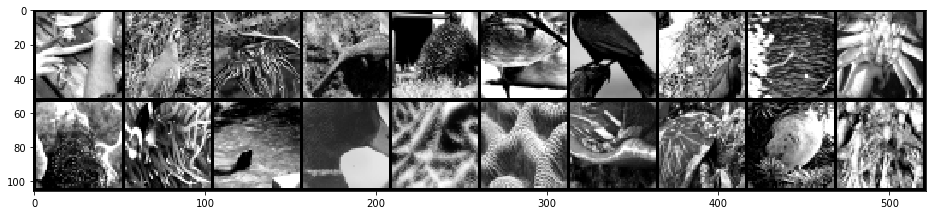

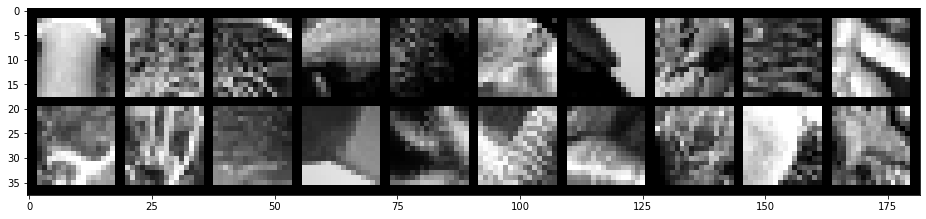

top
[3163 5087 3267 2713 5213 1575 7284  339 2988 5401 3570 5991 1172 2525
  568 6102 3676 4266 2601  643] [0.21354296 0.33662075 1.39534384 0.12213502 1.15349454 1.29149052
 0.54501605 1.35832447 1.52270601 0.62660434 1.22551656 0.40244341
 0.97963826 1.38163101 1.1937057  1.14757753 0.61807649 0.90112596
 0.26128602 1.15339294]
center slice(15, 31, None) slice(32, 48, None)
8.606591e-05 0.34012675


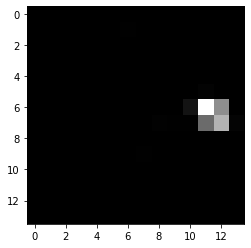

0.0 255.0
(20, 1, 16, 16)


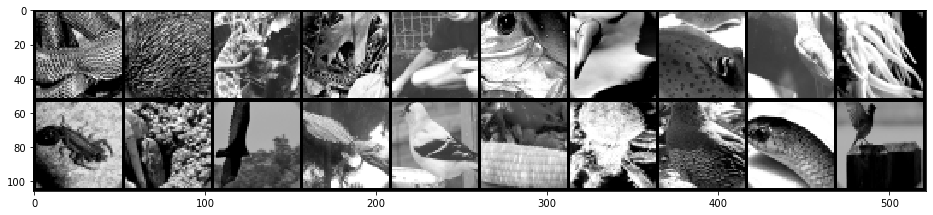

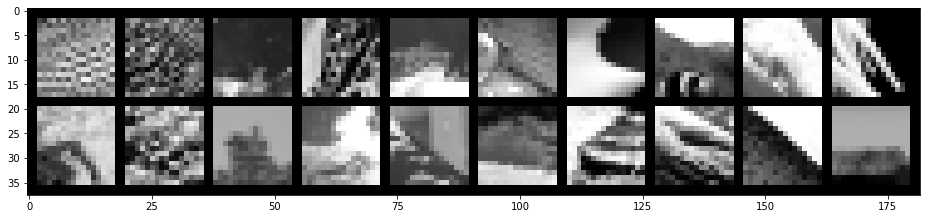

high
[ 594 1807 5966 6449 2988 5432 2657 3972 6563 6963 3267 5631  152 2525
 4862 1294 5007  339 5086 1887] [1.79123085 1.72550301 1.5943941  1.55753084 1.52270601 1.51403218
 1.4734591  1.44293864 1.4065115  1.4014599  1.39534384 1.38708528
 1.38577961 1.38163101 1.3766192  1.37565601 1.36848888 1.35832447
 1.35320848 1.35107439]
center slice(15, 31, None) slice(32, 48, None)
8.606591e-05 0.34012675


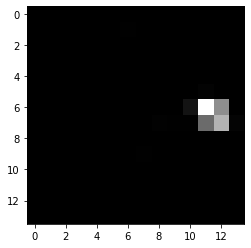

0.0 255.0
(20, 1, 16, 16)


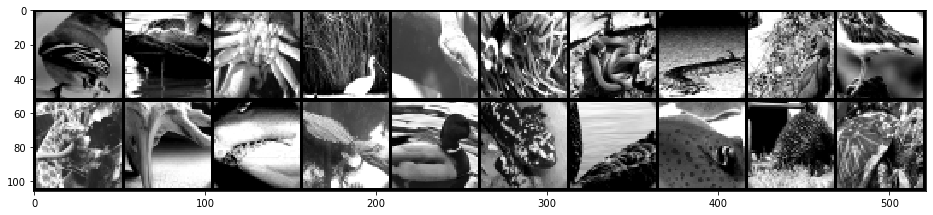

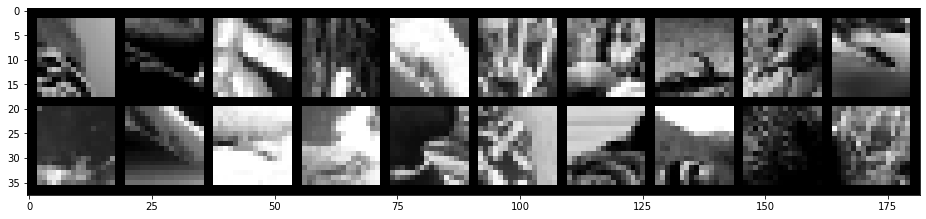

In [35]:
playaround()